In [1]:
library(brms) #predictability: Double hierearchical model
library(MCMCglmm) #HPDinterval
library(dplyr) #%>%
library(lmerTest) #lmer
#library(MuMIn) #r2
#library(merTools) #sim
library(sjPlot) #plot coeff
library(ggplot2) #ylim in plot
library(rstan) #model diagnostic

Warning message:
"le package 'brms' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Rcpp

Warning message:
"le package 'Rcpp' a été compilé avec la version R 4.1.2"
Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attachement du package : 'brms'


L'objet suivant est masqué depuis 'package:stats':

    ar


Warning message:
"le package 'MCMCglmm' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Matrix

Warning message:
"le package 'Matrix' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : coda

Warning message:
"le package 'coda' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : ape

Warning message:
"le package 'ape' a été compilé avec la version R 4.1.2"

Attachement du package : 'MCMCglmm'


L'objet suivant est masqué depuis 'pac

In [2]:
library(parallel)
my.cores = detectCores()-1 #minus 1 to avoid bocking the computer
my.cores

[1] 11

In [3]:
#ADD YOUR PATH TO SAVE OUTPUT (e.g.: 'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\')
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'

# Download data

In [4]:
#df = read.csv(file.path(path_,'df_daily_aggregatedHA.csv'), header = TRUE, sep = ",")
df = read.csv(file.path(path_,'df_BS.csv'), header = TRUE, sep = ",")

df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID)
df$TrackingSystemID = as.factor(df$TrackingSystemID)
df$level = as.factor(df$level) 
df$FoodPenID = as.factor(df$FoodPenID) 
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)

#scale: mean-centering of the environmental variable so that intercepts reflect average values for the HenID and ind. 
#df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)

#setting reference group
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "REXP"))
contrasts(df$CLASS)
print(dim(df))
summary(df)

df$WentinWG = as.integer(df$WentinWG)
df$Sleeping_Uppest = as.integer(df$Sleeping_Uppest)

df$KBFInterp = df$KBF_interp
df$weightInterp = df$weight_interp


dim(df)
df_time = df[df$BS_type=='time',]
dim(df_time)

df_LP2 = df[df$BS_type=='LP2',]
dim(df_LP2)

df_LP10 = df[df$BS_type=='LP10',]
dim(df_LP10)

df_cold = df[df$BS_type=='cold',]
dim(df_cold)

df_vacc = df[df$BS_type=='TypicalVaccinationDay',]
dim(df_vacc)

df_AC = df[df$across_context==1,]
dim(df_AC)

,OFH
TRAN,0
OFH,1


,LEXP,MEXP
REXP,0,0
LEXP,1,0
MEXP,0,1


[1] 5047   22


             TrackingSystemID        level           DOA             WOA       
 TrackingSystem 10-12:1907    2021-01-09: 159   Min.   :178.0   Min.   :26.00  
 TrackingSystem 3-5  :1927    2021-01-23: 158   1st Qu.:216.0   1st Qu.:31.00  
 TrackingSystem 8-9  :1213    2021-02-06: 158   Median :279.0   Median :40.00  
                              2021-04-17: 158   Mean   :282.1   Mean   :40.83  
                              2020-11-28: 157   3rd Qu.:338.0   3rd Qu.:49.00  
                              2021-05-01: 157   Max.   :416.0   Max.   :60.00  
                              (Other)   :4100                                  
      DIB                FoodPenID      BS_type          Treatment  
 Min.   : 60.0   FoodPenID1-4 :1267   Length:5047        TRAN:2483  
 1st Qu.: 98.0   FoodPenID5-8 :1246   Class :character   OFH :2564  
 Median :161.0   FoodPenID9-12:2534   Mode  :character              
 Mean   :164.1                                                      
 3rd Qu.:220.0 

[1] 5047   24

[1] 3196   24

[1] 468  24

[1] 444  24

[1] 471  24

[1] 468  24

[1] 613  24

# Define parameters

In [5]:
# Define parameters
#should be consistent across all notebooks
#ADD A NAME in case you want multiple run with all output saved each time
saving_name = 'TO ADD'
iter_ = 300000
iter_wu = 200000
#choose your dataframe (=df for all data, = df_LP10 for late life stage, =df_LP2 for early life stage)
df = df

In [6]:
#to delete when we send to publication
saving_name = 'ALLOBSNEWPenID'

# Multivariate models with correlated multilevel structure

#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula = scale(food_related_behavior_final_inv_cst) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+ (1|a|HenID), 
          data=df_time, family = gaussian())

In [7]:
#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
FA = bf(scale(food_sameDurTiming_r50_final) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+CLASS+ (1|a|HenID)+(1|PenID),
       family=gaussian)
VTD = bf(scale(vertical_travel_distance_fulllight_perinsideh) ~ Treatment + scale(weightInterp)+scale(KBFInterp)+scale(DIB) +CLASS+(1|a|HenID)+(1|PenID),
        family=gaussian)
TM = bf(mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) +CLASS+ (1|a|HenID)+(1|PenID),
       family=Gamma(link='log'))
SD = bf(Sleeping_Uppest ~ Treatment + scale(weightInterp)+scale(KBFInterp) + scale(DIB) +CLASS+ (1|a|HenID)+(1|PenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
WG = bf(WentinWG ~ Treatment+scale(weightInterp)+scale(KBFInterp) + scale(DIB)+CLASS+(1|a|HenID)+(1|PenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
get_prior(formula = FA + VTD + TM + SD + WG +
                    set_rescor(FALSE), 
          data=df, family = bernoulli())

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
lkj(1),cor,,,,,,,default
,cor,,HenID,,,,,default
,Intercept,,,,,,,default
,b,,,midcumZ4hMorning,,,,default
,b,CLASSLEXP,,midcumZ4hMorning,,,,default
,b,CLASSMEXP,,midcumZ4hMorning,,,,default
,b,scaleDIB,,midcumZ4hMorning,,,,default
,b,scaleKBFInterp,,midcumZ4hMorning,,,,default


In [8]:
#Add penID?

In [9]:
FA = bf(scale(food_sameDurTiming_r50_final) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+CLASS+ (1|a|HenID)+(1|PenID),
       family=gaussian)
VTD = bf(scale(vertical_travel_distance_fulllight_perinsideh) ~ Treatment + scale(weightInterp)+scale(KBFInterp)+scale(DIB) +CLASS+(1|a|HenID)+(1|PenID),
        family=gaussian)
TM = bf(mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS+(1|a|HenID)+(1|PenID),
       family=Gamma(link='log'))
SD = bf(Sleeping_Uppest ~ Treatment + scale(weightInterp)+scale(KBFInterp) + scale(DIB) + CLASS+(1|a|HenID)+(1|PenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
WG = bf(WentinWG ~ Treatment+scale(weightInterp)+scale(KBFInterp) + scale(DIB)+CLASS+(1|a|HenID)+(1|PenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
#by default, the first category will serve as the reference (https://discourse.mc-stan.org/t/example-with-family-multinomial/8707/3)
#so latency_1_Zone_15mn_3h will be left out and latency_1_Zone_15mn_3hOPP will be shown
#WG = bf(latency_1_Zone_15mn_3h_bind | trials(size) ~ Treatment +scale(DIB)+scale(weight_interp)+scale(KBF_interp)+(1|a|HenID), 
#        family = multinomial()) 
#NV = bf(nbr_visit_Z4_Morning_more60sec ~ Treatment +scale(weight_interp) + scale(DIB) + scale(KBF_interp) +(1|a|HenID),
#        family=poisson)
Multi_DHGLM = brm(FA + VTD + TM + SD + WG +
                    set_rescor(FALSE),
                    data = df,
                    iter = iter_, warmup = iter_wu, thin = 50,
                    chains = 4, cores =my.cores, seed = 12345)
summary(Multi_DHGLM) #95% Posterior HPD Interval
#save model (from: https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/horoscopes-insights.html#save-your-model-fits)
save(Multi_DHGLM, file = file.path(path_, paste0(saving_name, '_Multi_DHGLM_all_var_FINAL.rda')))
#load(file.path(path_,paste0(saving_name, '_Multi_DHGLM_all_var_FINAL.rda')))

Compiling Stan program...

Start sampling

Warning message:
"There were 208 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"There were 208 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


 Family: MV(gaussian, gaussian, gamma, bernoulli, bernoulli) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = log; shape = identity
         mu = logit
         mu = logit 
Formula: scale(food_sameDurTiming_r50_final) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS + (1 | a | HenID) + (1 | PenID) 
         scale(vertical_travel_distance_fulllight_perinsideh) ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS + (1 | a | HenID) + (1 | PenID) 
         mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS + (1 | a | HenID) + (1 | PenID) 
         Sleeping_Uppest ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS + (1 | a | HenID) + (1 | PenID) 
         WentinWG ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) + CLASS + (1 | a | HenID) + (1 | PenID) 
   Data: df (Number of observations: 5047) 
  Draws:

In [10]:
#load(file.path(path_,paste0(saving_name, '_Multi_DHGLM_all_var_FINAL.rda'))) #do not put modelreload = load(file.path(path_,"Multi_DHGLM_allvar_Food2.rda"))

### saving some outputs

In [11]:
#coefficient of variation in predictability” (CVP)
#log.norm.res = exp(posterior_samples(Multi_DHGLM)$"sd_HenID__sigma_Intercept"^2)
#CVP = sqrt(log.norm.res-1)
#mean(CVP);HPDinterval(as.mcmc(CVP),0.95)

#posterior samples dimensionality of the dataframe:
#nrw=(iter-warup)/thin * chain
#ncol=#param to estimate
prior_summary(Multi_DHGLM)

#all data, sd in python
#extract samples (draw) from the posterior distribution, including all variables
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
colnames(posterior_samples(Multi_DHGLM))[1:30]
df_pred = as_draws(Multi_DHGLM)
length(df_pred[[1]]) #nbr param
length(df_pred[[1]][[1]]) #nbr posterior samples we got per chain
write.csv(df_pred, file.path(path_,paste0(saving_name,'_BRMS_BS_pred_allvar_FINAL.csv')), row.names = TRUE)

#only mean and CI from R
df_pred = posterior_samples(Multi_DHGLM)
dim(df_pred) # nbr posterior samles we got, #param
#--> (1250, 4044) ou (5000, 1011)
df_mean = colMeans(df_pred)
df_CI = HPDinterval(as.mcmc(df_pred))
dim(df_CI)
write.csv(df_CI, file.path(path_,paste0(saving_name,'_df_CI_BRMS_BS_pred_allvar_FINAL.csv')), row.names = TRUE)
write.csv(df_mean, file.path(path_,paste0(saving_name,'_df_mean_BRMS_BS_pred_allvar_FINAL.csv')), row.names = TRUE)
dim(df)

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,midcumZ4hMorning,,,,default
,b,CLASSLEXP,,midcumZ4hMorning,,,,default
,b,CLASSMEXP,,midcumZ4hMorning,,,,default
,b,scaleDIB,,midcumZ4hMorning,,,,default
,b,scaleKBFInterp,,midcumZ4hMorning,,,,default
,b,scaleweightInterp,,midcumZ4hMorning,,,,default
,b,TreatmentOFH,,midcumZ4hMorning,,,,default
,b,,,scalefoodsameDurTimingr50final,,,,default
,b,CLASSLEXP,,scalefoodsameDurTimingr50final,,,,default


Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] "b_scalefoodsameDurTimingr50final_Intercept"                        
 [2] "b_scaleverticaltraveldistancefulllightperinsideh_Intercept"        
 [3] "b_midcumZ4hMorning_Intercept"                                      
 [4] "b_SleepingUppest_Intercept"                                        
 [5] "b_WentinWG_Intercept"                                              
 [6] "b_scalefoodsameDurTimingr50final_TreatmentOFH"                     
 [7] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID5M8"            
 [8] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID9M12"           
 [9] "b_scalefoodsameDurTimingr50final_scaleweightInterp"                
[10] "b_scalefoodsameDurTimingr50final_scaleKBFInterp"                   
[11] "b_scalefoodsameDurTimingr50final_scaleDIB"                         
[12] "b_scalefoodsameDurTimingr50final_CLASSLEXP"                        
[13] "b_scalefoodsameDurTimingr50final_CLASSMEXP"                        
[14] "b_scaleverticaltraveldistancefulllightperinsideh_TreatmentOFH"     
[15] "b_scaleverticaltraveldistancefulllightperinsideh_scaleweightInterp"
[16] "b_scaleverticaltraveldistancefulllightperinsideh_scaleKBFInterp"   
[17] "b_scaleverticaltraveldistancefulllightperinsideh_scaleDIB"         
[18] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSLEXP"        
[19] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSMEXP"        
[20] "b_midcumZ4hMorning_TreatmentOFH"                                   
[21] "b_midcumZ4hMorning_scaleweightInterp"                              
[22] "b_midcumZ4hMorning_scaleKBFInterp"                                 
[23] "b_midcumZ4hMorning_scaleDIB"                                       
[24] "b_midcumZ4hMorning_CLASSLEXP"                                      
[25] "b_midcumZ4hMorning_CLASSMEXP"                                      
[26] "b_SleepingUppest_TreatmentOFH"                                     
[27] "b_SleepingUppest_scaleweightInterp"                                
[28] "b_SleepingUppest_scaleKBFInterp"                                   
[29] "b_SleepingUppest_scaleDIB"                                         
[30] "b_SleepingUppest_CLASSLEXP"

[1] 1071

[1] 2000

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 8000 1071

[1] 1071    2

[1] 5047   24

In [12]:
#mean population-level estimates
fixef(Multi_DHGLM)
p1 = plot_model(Multi_DHGLM,  show.values = TRUE, title='Population-Level Effects', 
            rm.terms = c('FoodPenIDFoodPenID9M12','FoodPenIDFoodPenID5M8'), #TreatmentOFH
                type = "est", colors = c("red3", "forestgreen"))+ ylim(-.6, .6)
ggsave(file.path(path_,paste0(saving_name,'_Multi_fixedestimate_withOFH_FINAL.png')), plot=p1, height=5, width=12, dpi=600) 

p1 = plot_model(Multi_DHGLM,  show.values = TRUE, title='Population-Level Effects', 
            rm.terms = c('TreatmentOFH','FoodPenIDFoodPenID9M12','FoodPenIDFoodPenID5M8','CLASSMEXP','CLASSLEXP'), #TreatmentOFH
                type = "est", colors = c("red3", "forestgreen"))+ ylim(-.6, .6)
ggsave(file.path(path_,paste0(saving_name,'_Multi_fixedestimate_withoutOFHCLASS_FINAL.png')), plot=p1, dpi=600) #height=5, width=12,
#or in terms of density: https://www.rensvandeschoot.com/tutorials/generalised-linear-models-with-brms/
#stanplot(Multi_DHGLM, type = "areas", prob = 0.95)
#darkgreen, forestgreen ; firebrick, red3
#ex of interpretation: https://www.rensvandeschoot.com/tutorials/generalised-linear-models-with-brms/

,Estimate,Est.Error,Q2.5,Q97.5
scalefoodsameDurTimingr50final_Intercept,0.116415904,0.142348892,-0.164266084,0.389168070
scaleverticaltraveldistancefulllightperinsideh_Intercept,-0.012403714,0.119429712,-0.248843329,0.224749724
midcumZ4hMorning_Intercept,1.487816313,0.022352677,1.443445666,1.532513066
SleepingUppest_Intercept,1.659875924,0.360378762,0.959081941,2.380475228
WentinWG_Intercept,0.916680552,0.399629377,0.121079429,1.716510635
scalefoodsameDurTimingr50final_TreatmentOFH,-0.120184675,0.125752450,-0.361908978,0.135004251
scalefoodsameDurTimingr50final_FoodPenIDFoodPenID5M8,-0.067389149,0.171409952,-0.403636719,0.265302093
scalefoodsameDurTimingr50final_FoodPenIDFoodPenID9M12,-0.127300135,0.150005748,-0.413284394,0.169252173
scalefoodsameDurTimingr50final_scaleweightInterp,-0.031718710,0.029186966,-0.089939569,0.024754029
scalefoodsameDurTimingr50final_scaleKBFInterp,0.003305617,0.023928956,-0.043788398,0.049985767


Warning message in (function (..., deparse.level = 1) :
"number of columns of result is not a multiple of vector length (arg 3)"
Warning message in (function (..., deparse.level = 1) :
"number of columns of result is not a multiple of vector length (arg 3)"
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 3 rows containing missing values (geom_rect)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."
Warning message:
"Removed 2 rows containing missing values (geom_text)."
Warning message in (function (..., deparse.level = 1) :
"number of columns of result is not a multiple of vector length (arg 3)"
Warning message in (function (..., deparse.level = 1) :
"number of columns of result is not a multiple of vector length (arg 3)"
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Saving 6.67 x 6.67 in image



Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] "b_scalefoodsameDurTimingr50final_Intercept"                                                                   
 [2] "b_scaleverticaltraveldistancefulllightperinsideh_Intercept"                                                   
 [3] "b_midcumZ4hMorning_Intercept"                                                                                 
 [4] "b_SleepingUppest_Intercept"                                                                                   
 [5] "b_WentinWG_Intercept"                                                                                         
 [6] "b_scalefoodsameDurTimingr50final_TreatmentOFH"                                                                
 [7] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID5M8"                                                       
 [8] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID9M12"                                                      
 [9] "b_scalefoodsameDurTimingr50final_scaleweightInterp"                                                           
[10] "b_scalefoodsameDurTimingr50final_scaleKBFInterp"                                                              
[11] "b_scalefoodsameDurTimingr50final_scaleDIB"                                                                    
[12] "b_scalefoodsameDurTimingr50final_CLASSLEXP"                                                                   
[13] "b_scalefoodsameDurTimingr50final_CLASSMEXP"                                                                   
[14] "b_scaleverticaltraveldistancefulllightperinsideh_TreatmentOFH"                                                
[15] "b_scaleverticaltraveldistancefulllightperinsideh_scaleweightInterp"                                           
[16] "b_scaleverticaltraveldistancefulllightperinsideh_scaleKBFInterp"                                              
[17] "b_scaleverticaltraveldistancefulllightperinsideh_scaleDIB"                                                    
[18] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSLEXP"                                                   
[19] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSMEXP"                                                   
[20] "b_midcumZ4hMorning_TreatmentOFH"                                                                              
[21] "b_midcumZ4hMorning_scaleweightInterp"                                                                         
[22] "b_midcumZ4hMorning_scaleKBFInterp"                                                                            
[23] "b_midcumZ4hMorning_scaleDIB"                                                                                  
[24] "b_midcumZ4hMorning_CLASSLEXP"                                                                                 
[25] "b_midcumZ4hMorning_CLASSMEXP"                                                                                 
[26] "b_SleepingUppest_TreatmentOFH"                                                                                
[27] "b_SleepingUppest_scaleweightInterp"                                                                           
[28] "b_SleepingUppest_scaleKBFInterp"                                                                              
[29] "b_SleepingUppest_scaleDIB"                                                                                    
[30] "b_SleepingUppest_CLASSLEXP"                                                                                   
[31] "b_SleepingUppest_CLASSMEXP"                                                                                   
[32] "b_WentinWG_TreatmentOFH"                                                                                      
[33] "b_WentinWG_scaleweightInterp"                                                                                 
[34] "b_WentinWG_scaleKBFInterp"                                                                                    
[35] "b_WentinWG_scaleD

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,0.3470535,0.5937028


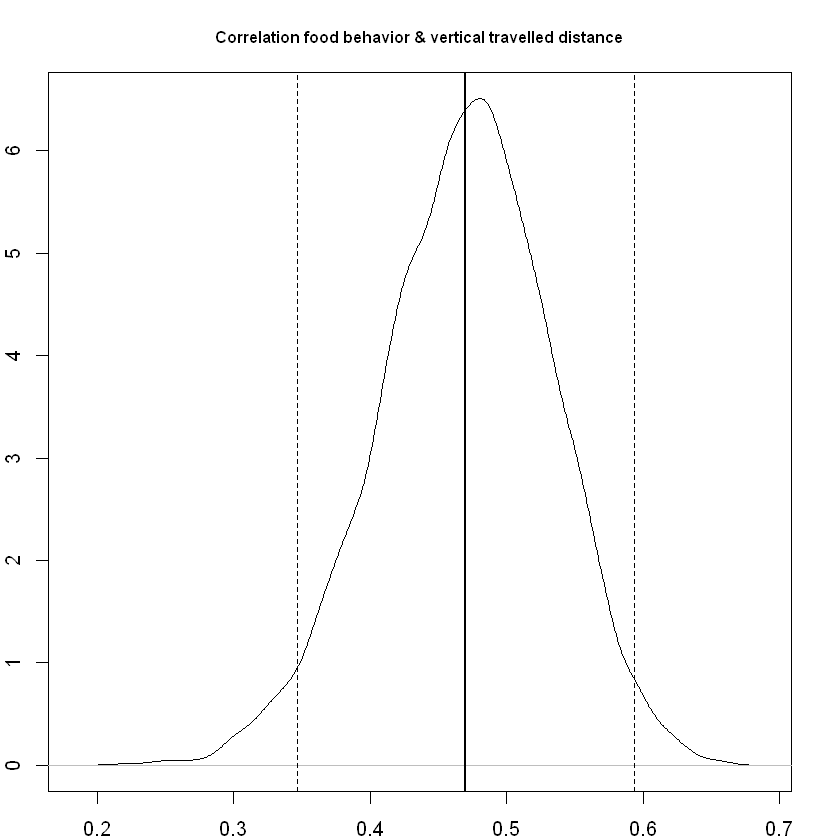

In [13]:
colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__scalefoodsameDurTimingr50final_Intercept__scaleverticaltraveldistancefulllightperinsideh_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation food behavior & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,-0.3864289,-0.08467919


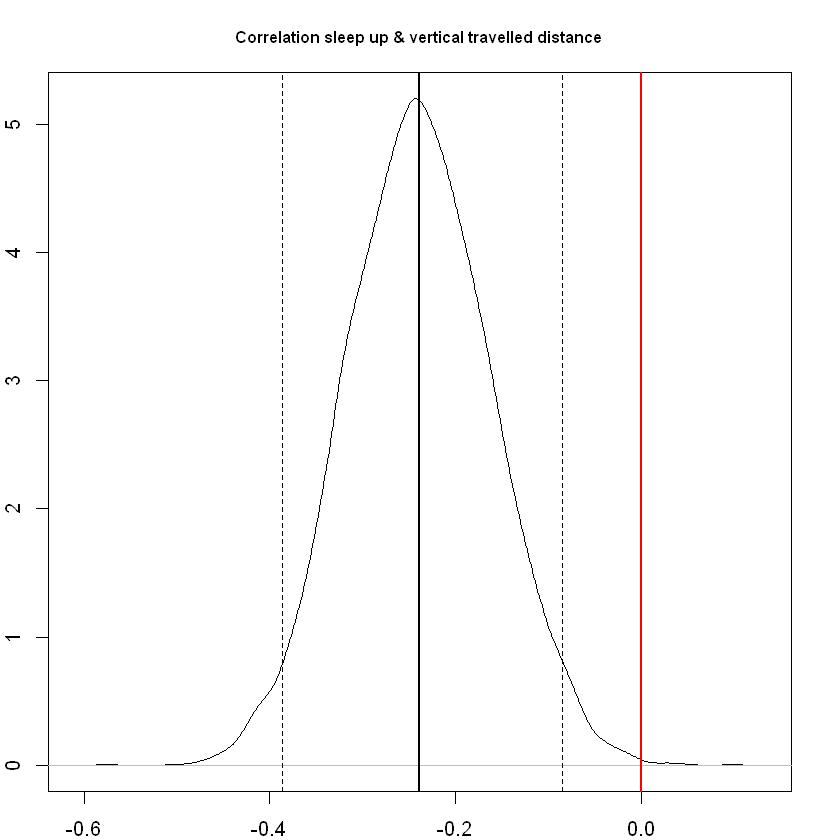

In [14]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__scaleverticaltraveldistancefulllightperinsideh_Intercept__SleepingUppest_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation sleep up & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,0.1305917,0.4269753


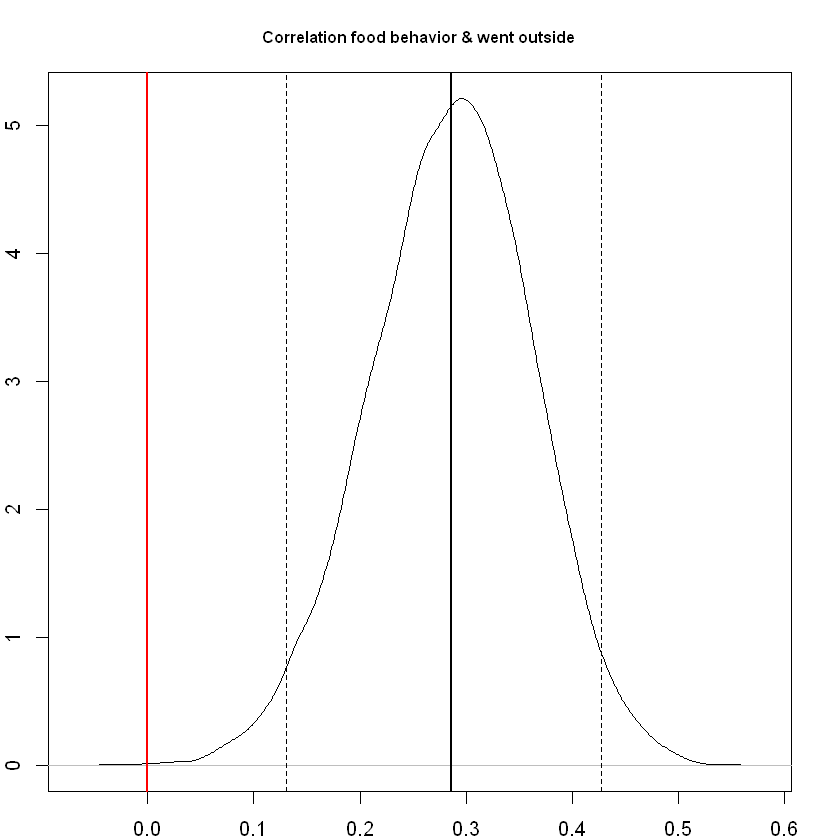

In [15]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__scalefoodsameDurTimingr50final_Intercept__WentinWG_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation food behavior & went outside",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,0.377156,0.6124622


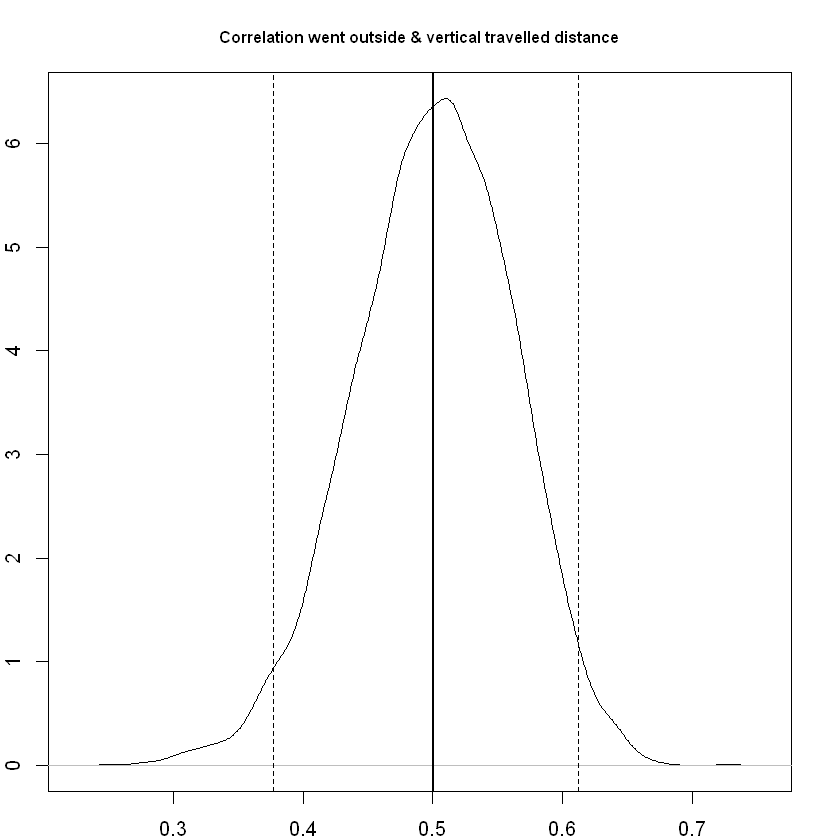

In [16]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__scaleverticaltraveldistancefulllightperinsideh_Intercept__WentinWG_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation went outside & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


,lower,upper
var1,-0.3674107,-0.05452768


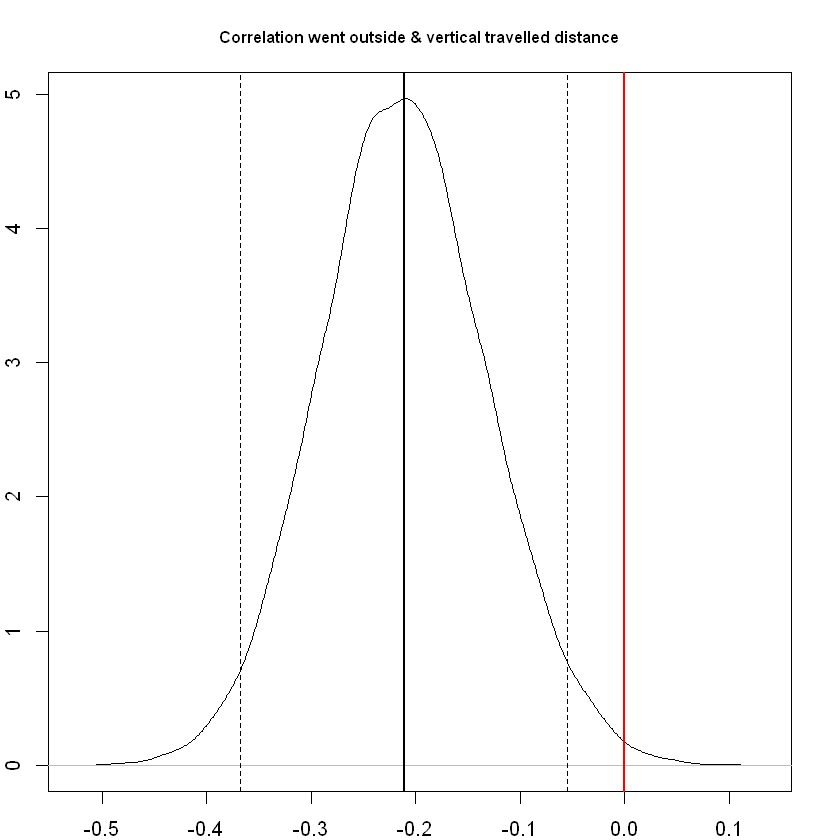

In [17]:
#colnames(posterior_samples(Multi_DHGLM))[1:60]
#plot the among individual correlation of behaviors: Correlation between mean behavioral expression of MVT1 and MVT2, where the dashedlines 
#indicate the 95% credible interval of the posterior distribution.
food_VT = posterior_samples(Multi_DHGLM)[,'cor_HenID__scalefoodsameDurTimingr50final_Intercept__SleepingUppest_Intercept']
#same:
#food_VT <-posterior_samples(Multi_DHGLM)$cor_HenID__foodrelatedbehaviorfinalinvcst_Intercept__scaleVTD_Intercept
par(mar=c(2, 2, 3, 2))
plot(density(food_VT),main="Correlation went outside & vertical travelled distance",xlab="",ylab="",cex.main=0.8)
abline(v=0,col="red",lwd=2)
abline(v=mean(food_VT),col="black",lwd=2)
abline(v=HPDinterval(as.mcmc(food_VT))[1],col="black",lty=2)
abline(v=HPDinterval(as.mcmc(food_VT))[2],col="black",lty=2)
HPDinterval(as.mcmc(food_VT))

### model diagnostic

In [18]:
#load(file.path(path_,paste0(saving_name, '_Multi_DHGLM_all_var_FINAL.rda')))

Warning message:
"
381 (7.5%) p_waic estimates greater than 0.4. We recommend trying loo instead."
Warning message:
"Found 3 observations with a pareto_k > 0.7 in model 'Multi_DHGLM'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. "


[1] "----------------------- waic"

Computed from 8000 by 5047 log-likelihood matrix

          Estimate    SE
elpd_waic -20988.5 144.8
p_waic       844.5  13.9
waic       41977.1 289.7

381 (7.5%) p_waic estimates greater than 0.4. We recommend trying loo instead. 
[1] "----------------------- loo-cv"

Computed from 8000 by 5047 log-likelihood matrix

         Estimate    SE
elpd_loo -20993.7 144.9
p_loo       849.6  14.2
looic     41987.3 289.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     5030  99.7%   463       
 (0.5, 0.7]   (ok)         14   0.3%   194       
   (0.7, 1]   (bad)         3   0.1%   19        
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.
[1] "----------------------- loo2"



Computed from 8000 by 5047 log-likelihood matrix

         Estimate    SE
elpd_loo -20993.7 144.9
p_loo       849.6  14.2
looic     41987.3 289.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     5030  99.7%   463       
 (0.5, 0.7]   (ok)         14   0.3%   194       
   (0.7, 1]   (bad)         3   0.1%   19        
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.

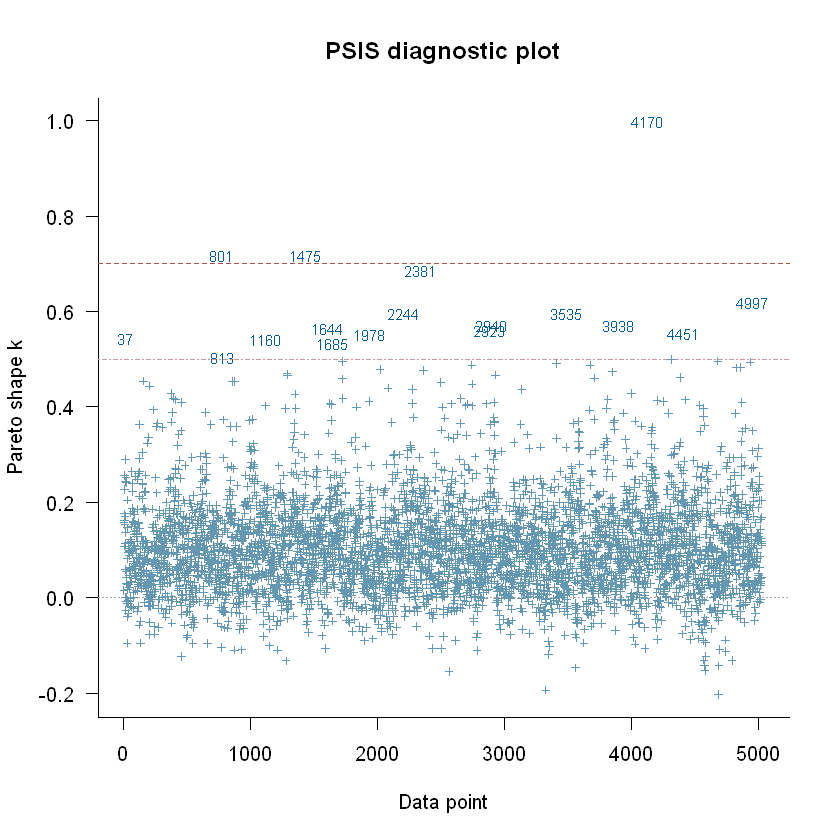

In [19]:
############## Loo-cv and waic ##############
#conditional_effects(Multi_DHGLM)
Multi_DHGLM = add_criterion(Multi_DHGLM, criterion=c('waic','loo'), file=file.path(path_,paste0(saving_name,'_Multi_DHGLM_allvar_FINAL')))
#head(get_variables(modelPred),10)
print('----------------------- waic')
print(Multi_DHGLM$criteria$waic)

print('----------------------- loo-cv')
#approximative leave-one-out cross validation
print(Multi_DHGLM$criteria$loo)

print('----------------------- loo2')
#check highly influential observations
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-moment-matching.html
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-example.html
#"If we had a well-specified model we would expect the estimated effective number of parameters (p_loo) to be smaller than or 
#similar to the total number of parameters in the model."
loo2 = loo(Multi_DHGLM, moment_match = TRUE)
loo2
plot(loo2, label_points = TRUE)

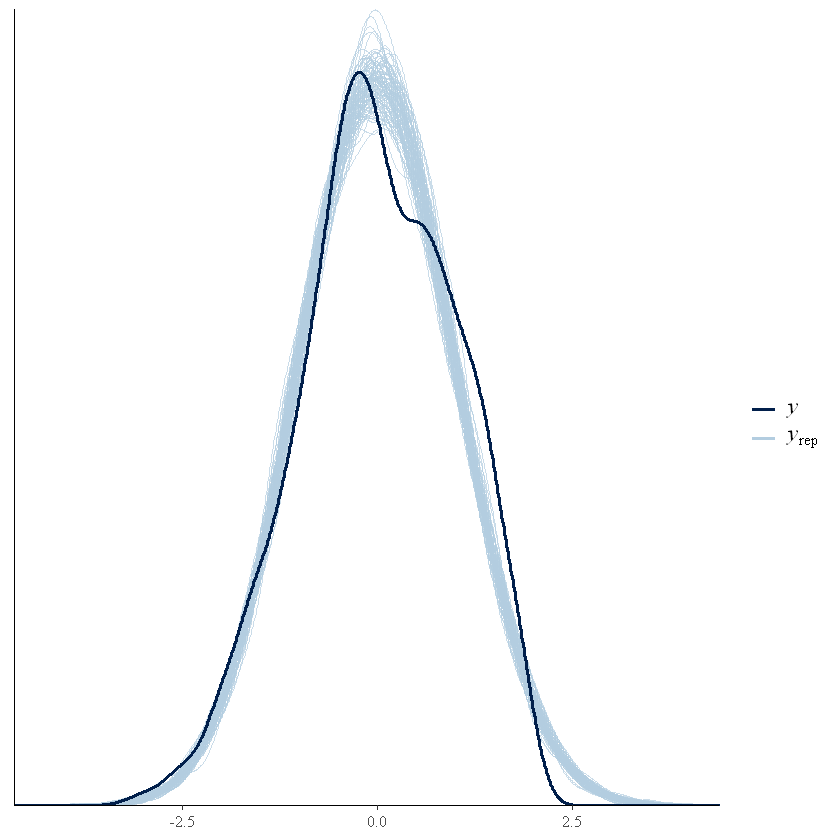

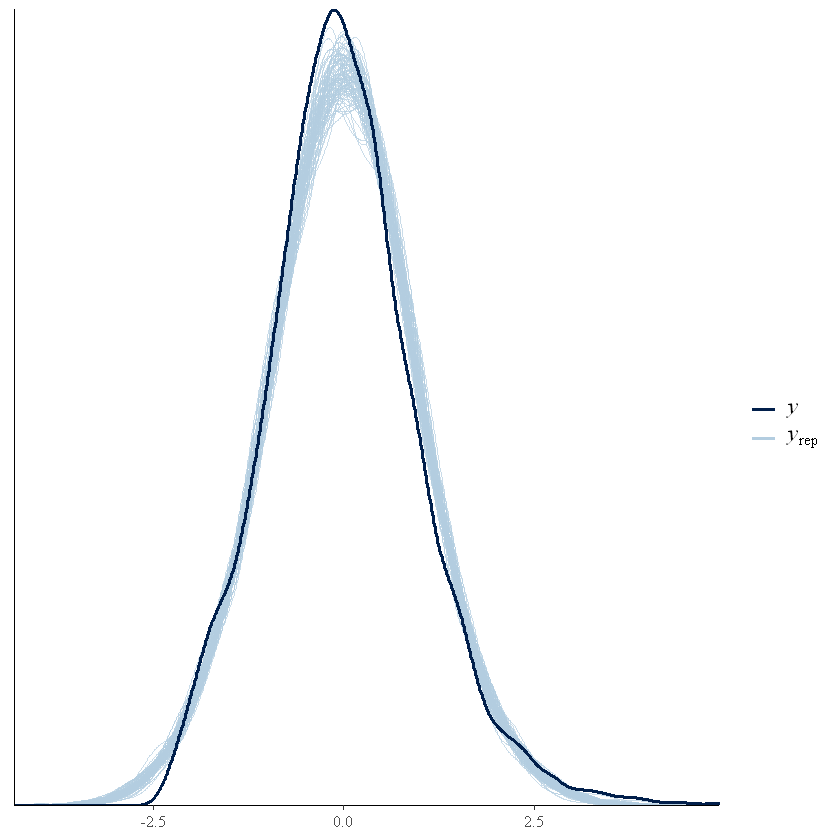

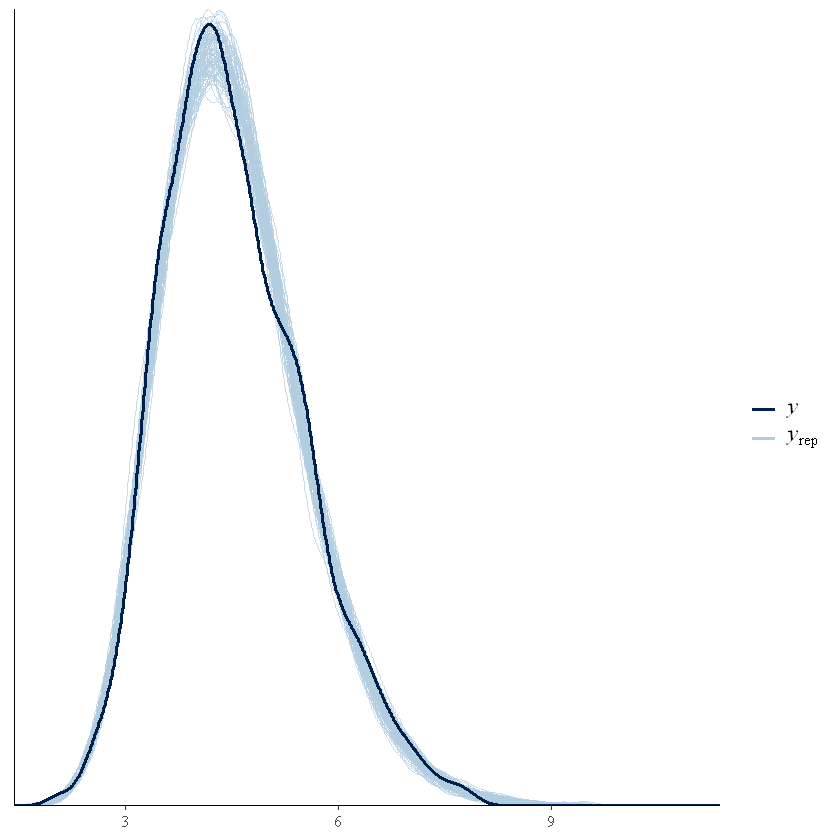

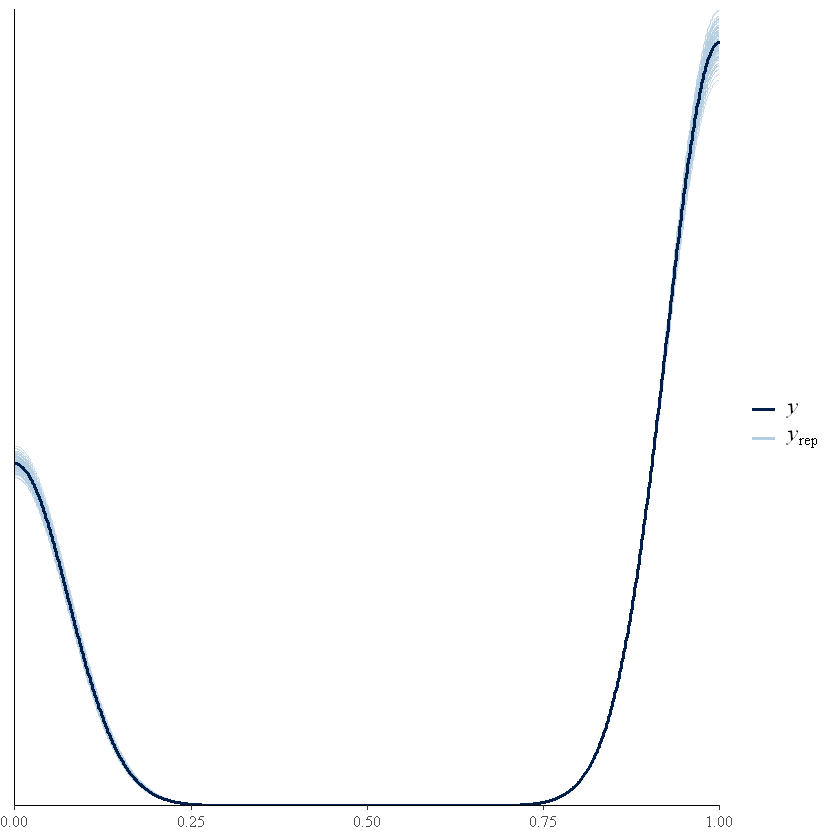

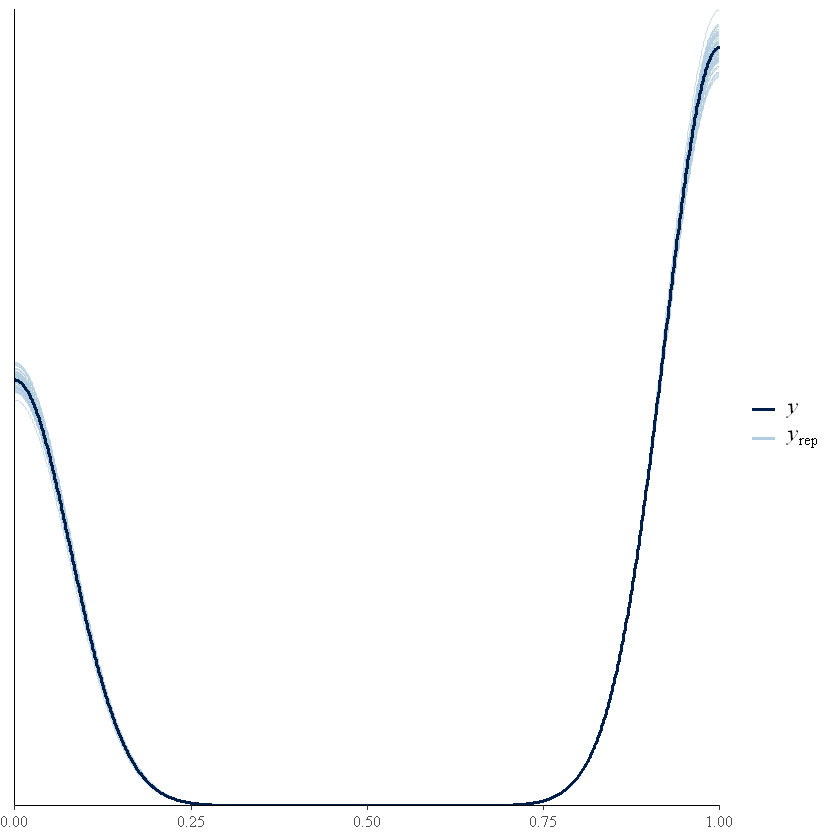

In [20]:
############## posterior predictive check ##############
pp_check(Multi_DHGLM, resp='scalefoodsameDurTimingr50final',ndraws = 100)
pp_check(Multi_DHGLM, resp='scaleverticaltraveldistancefulllightperinsideh',ndraws = 100)
pp_check(Multi_DHGLM, resp='midcumZ4hMorning',ndraws = 100)
pp_check(Multi_DHGLM, resp='SleepingUppest',ndraws = 100)
pp_check(Multi_DHGLM, resp='WentinWG',ndraws = 100)

[1] 1071

[1] 61

[1] "b_scalefoodsameDurTimingr50final_Intercept"                                                                   
 [2] "b_scaleverticaltraveldistancefulllightperinsideh_Intercept"                                                   
 [3] "b_midcumZ4hMorning_Intercept"                                                                                 
 [4] "b_SleepingUppest_Intercept"                                                                                   
 [5] "b_WentinWG_Intercept"                                                                                         
 [6] "b_scalefoodsameDurTimingr50final_TreatmentOFH"                                                                
 [7] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID5M8"                                                       
 [8] "b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID9M12"                                                      
 [9] "b_scalefoodsameDurTimingr50final_scaleweightInterp"                                                           
[10] "b_scalefoodsameDurTimingr50final_scaleKBFInterp"                                                              
[11] "b_scalefoodsameDurTimingr50final_scaleDIB"                                                                    
[12] "b_scalefoodsameDurTimingr50final_CLASSLEXP"                                                                   
[13] "b_scalefoodsameDurTimingr50final_CLASSMEXP"                                                                   
[14] "b_scaleverticaltraveldistancefulllightperinsideh_TreatmentOFH"                                                
[15] "b_scaleverticaltraveldistancefulllightperinsideh_scaleweightInterp"                                           
[16] "b_scaleverticaltraveldistancefulllightperinsideh_scaleKBFInterp"                                              
[17] "b_scaleverticaltraveldistancefulllightperinsideh_scaleDIB"                                                    
[18] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSLEXP"                                                   
[19] "b_scaleverticaltraveldistancefulllightperinsideh_CLASSMEXP"                                                   
[20] "b_midcumZ4hMorning_TreatmentOFH"                                                                              
[21] "b_midcumZ4hMorning_scaleweightInterp"                                                                         
[22] "b_midcumZ4hMorning_scaleKBFInterp"                                                                            
[23] "b_midcumZ4hMorning_scaleDIB"                                                                                  
[24] "b_midcumZ4hMorning_CLASSLEXP"                                                                                 
[25] "b_midcumZ4hMorning_CLASSMEXP"                                                                                 
[26] "b_SleepingUppest_TreatmentOFH"                                                                                
[27] "b_SleepingUppest_scaleweightInterp"                                                                           
[28] "b_SleepingUppest_scaleKBFInterp"                                                                              
[29] "b_SleepingUppest_scaleDIB"                                                                                    
[30] "b_SleepingUppest_CLASSLEXP"                                                                                   
[31] "b_SleepingUppest_CLASSMEXP"                                                                                   
[32] "b_WentinWG_TreatmentOFH"                                                                                      
[33] "b_WentinWG_scaleweightInterp"                                                                                 
[34] "b_WentinWG_scaleKBFInterp"                                                                                    
[35] "b_WentinWG_scaleD

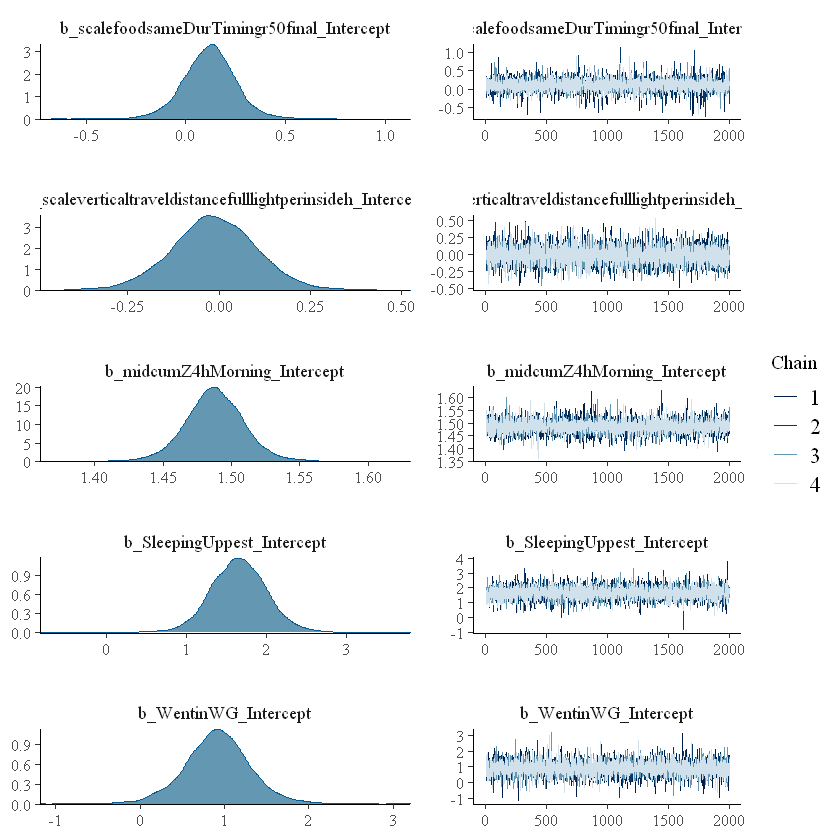

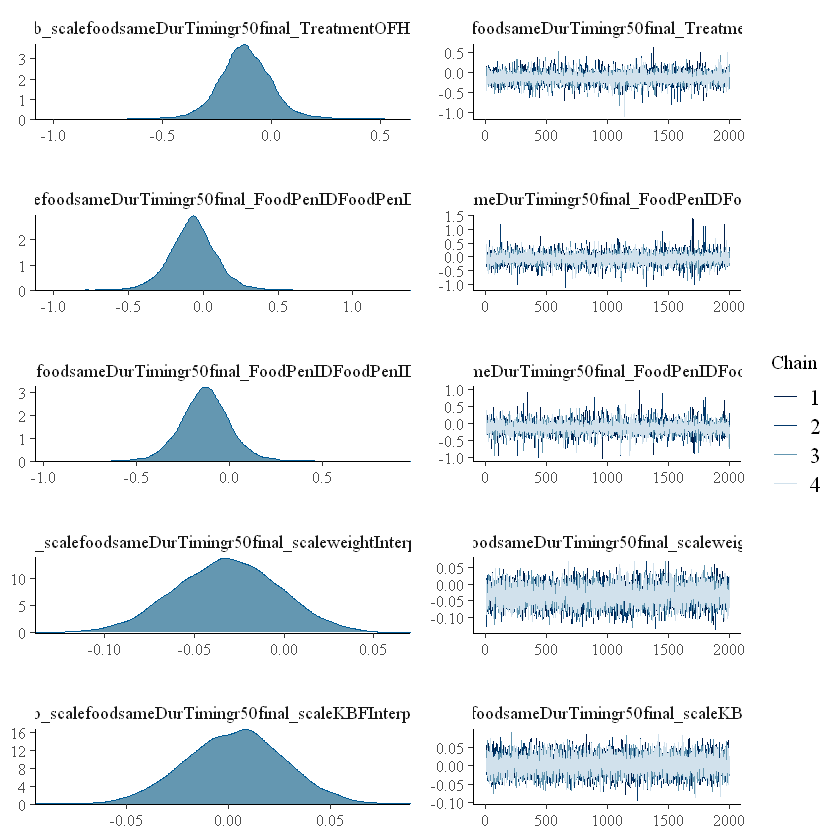

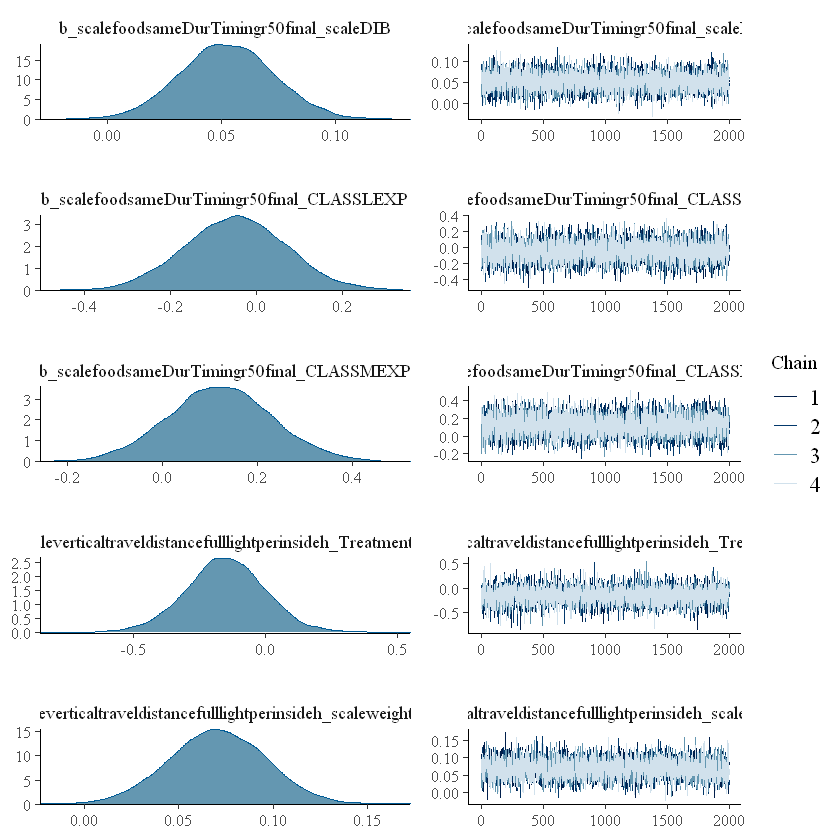

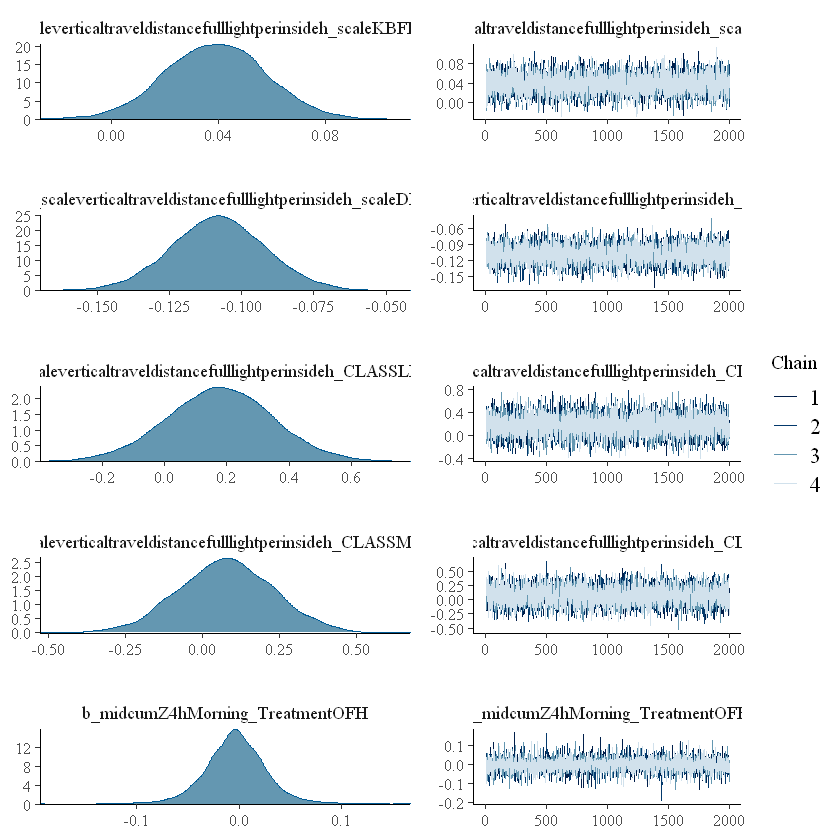

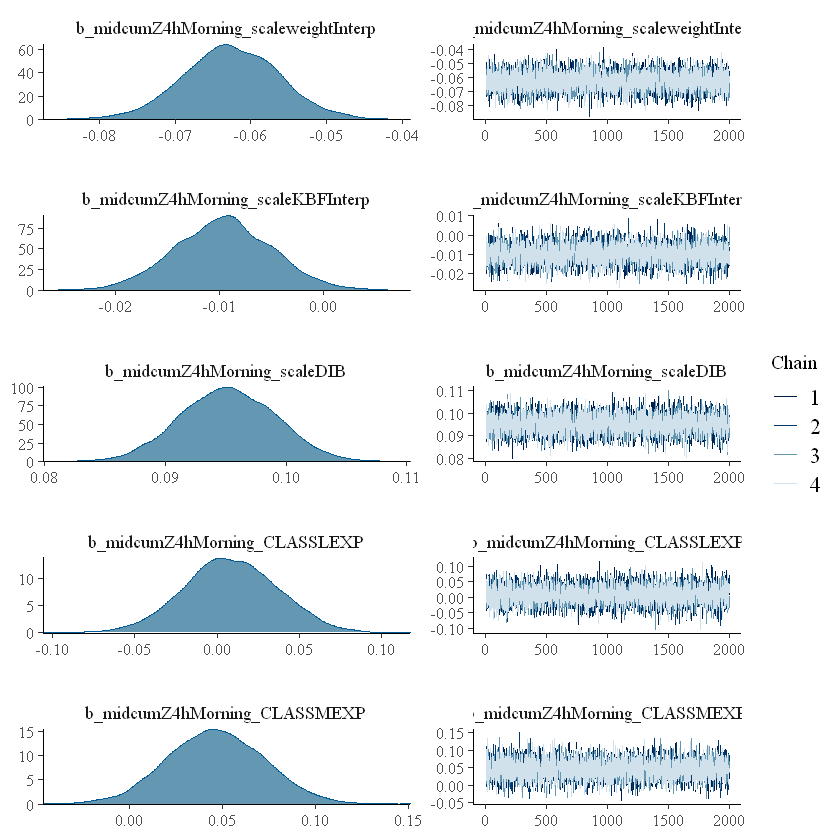

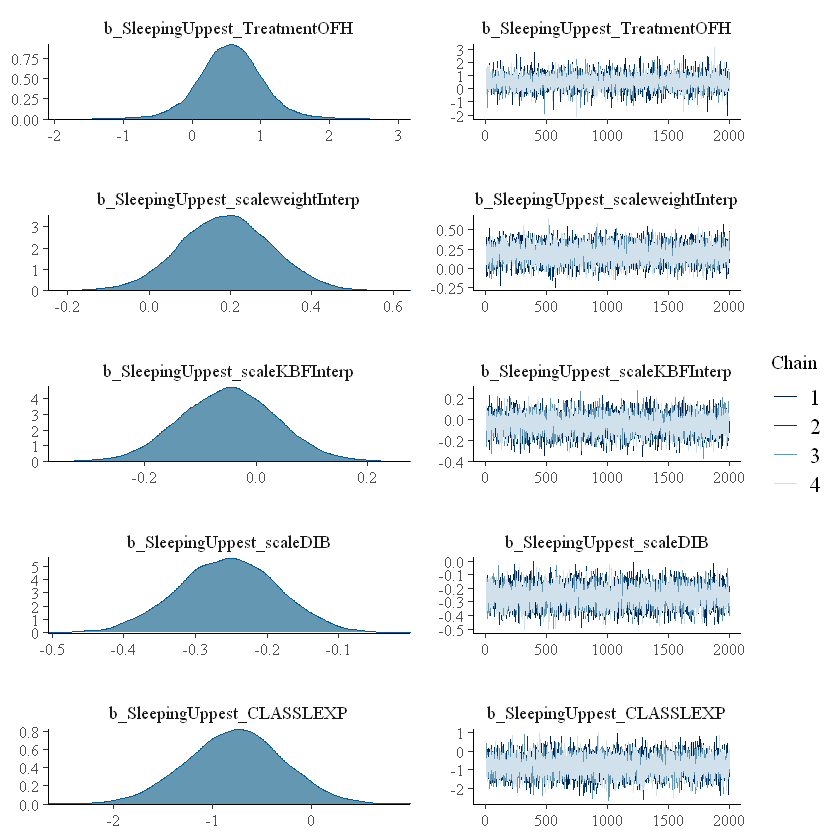

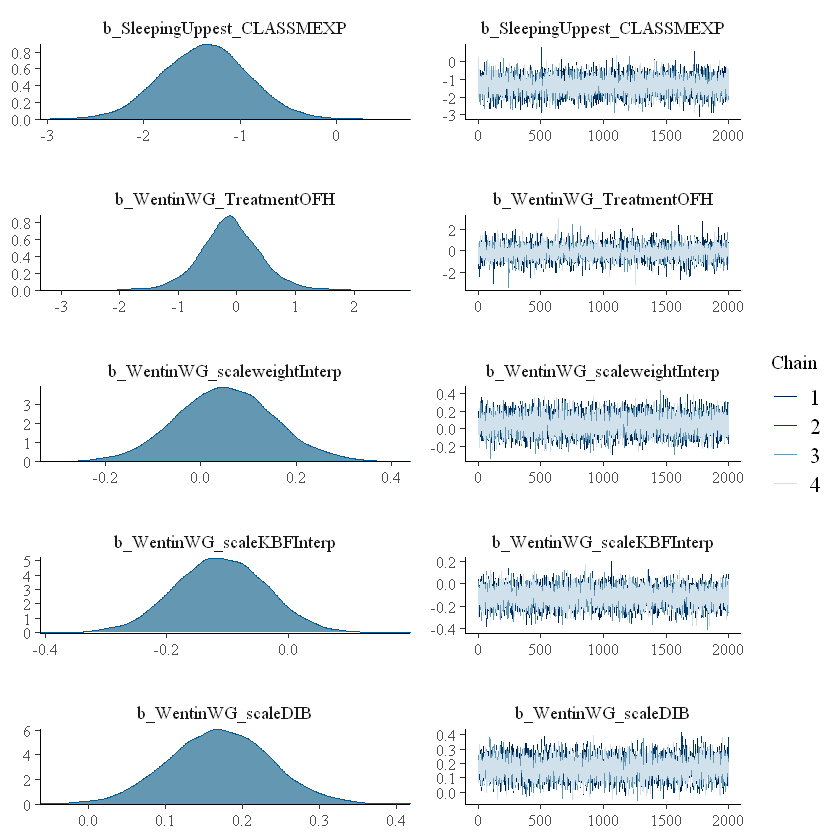

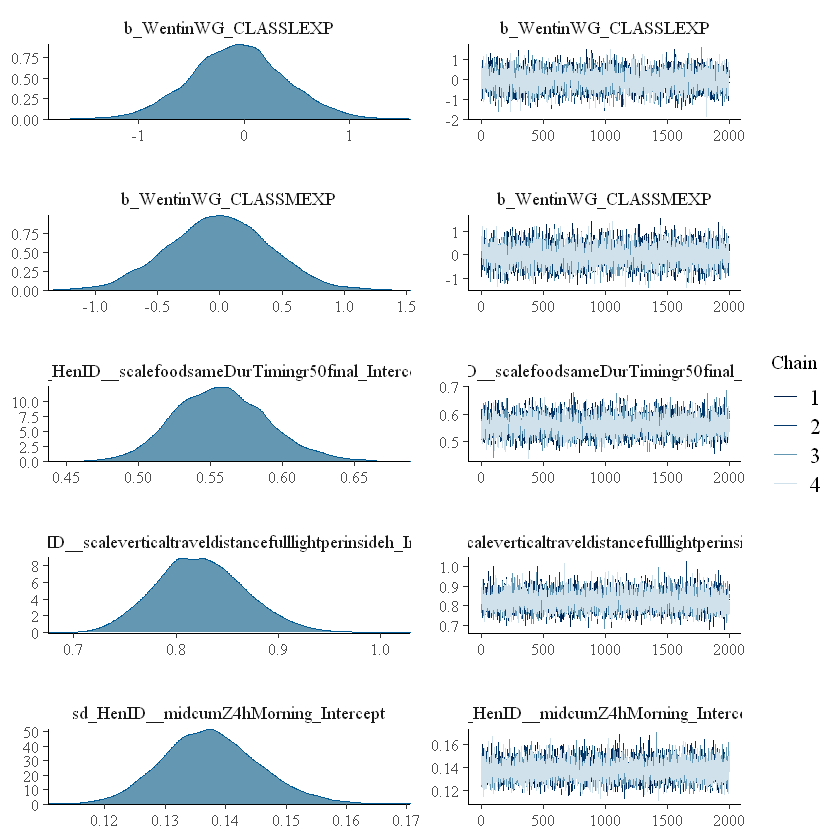

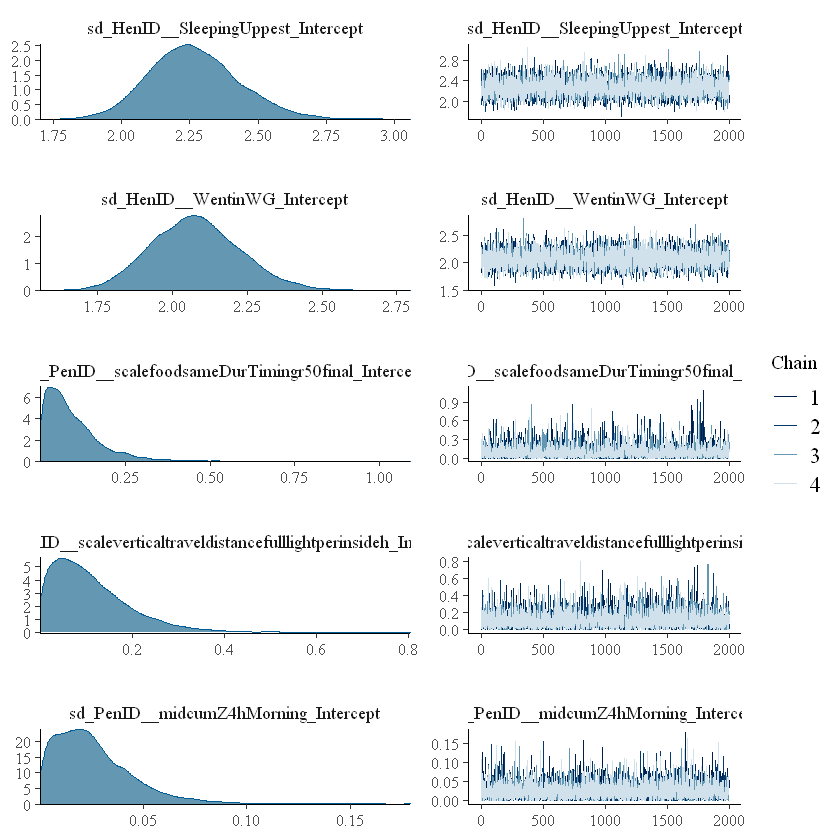

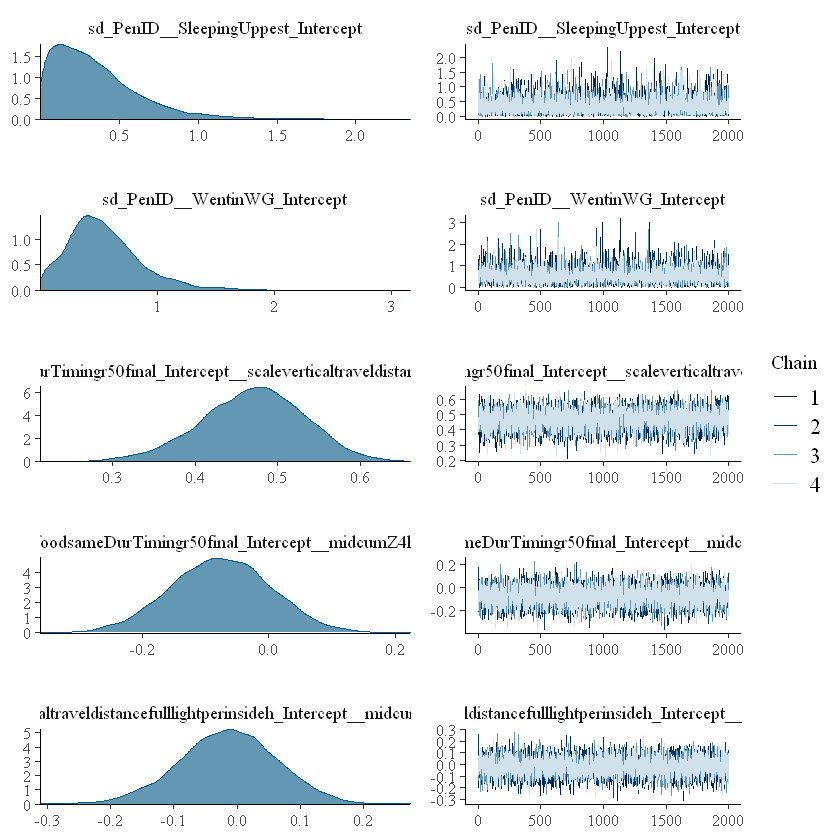

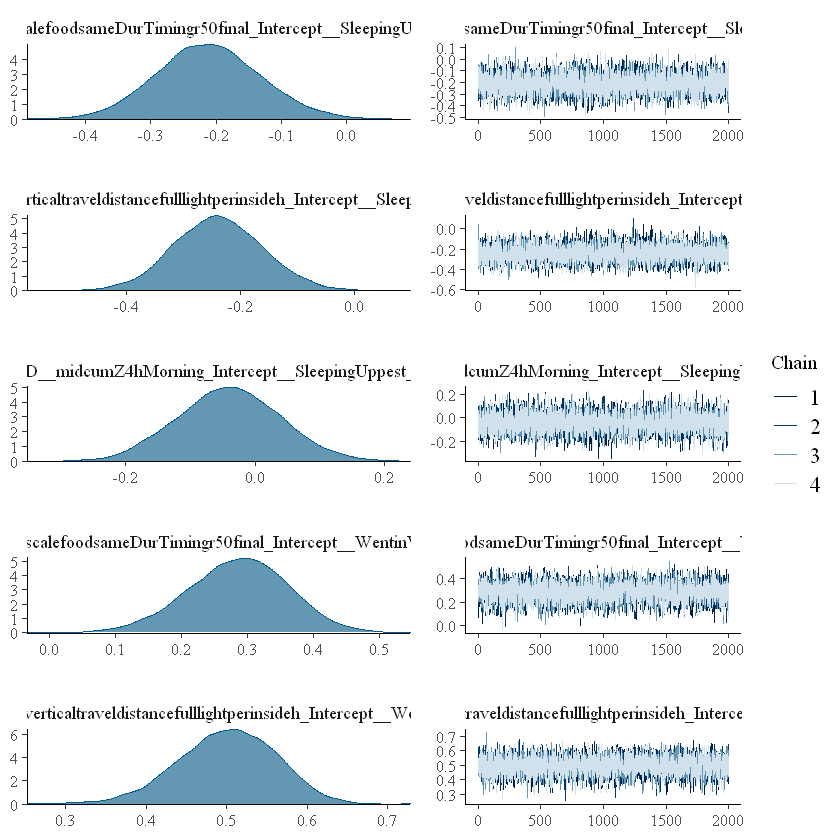

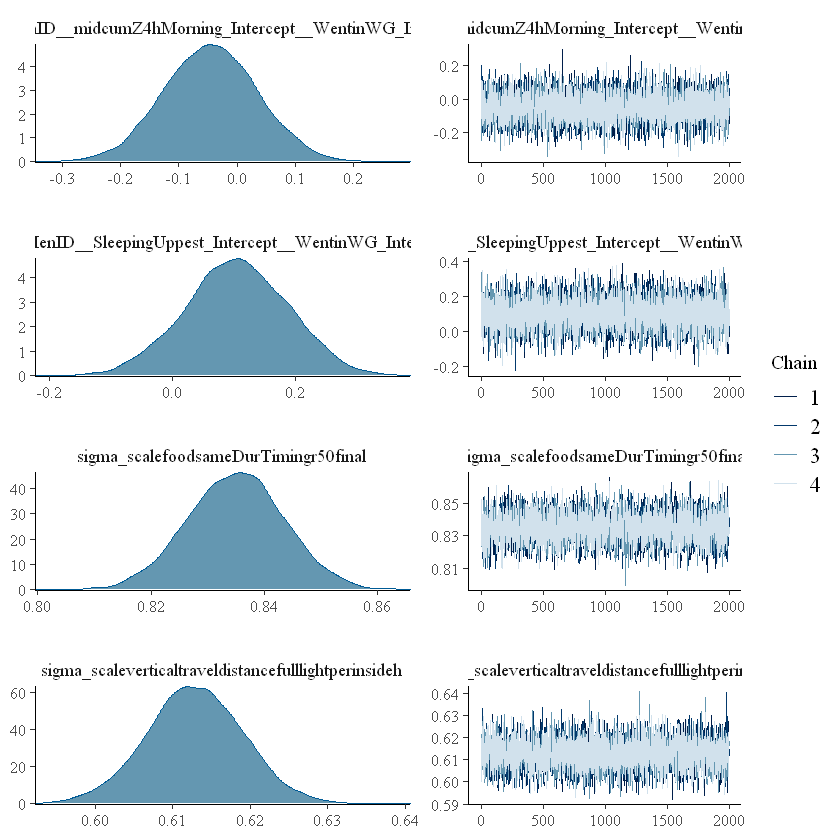

In [21]:
############## trace plot ##############
#variables(Multi_DHGLM) #extract parameter names
length(variables(Multi_DHGLM)) #nbr of param
li_param = variables(Multi_DHGLM)
cond = lapply(li_param, function(x) !startsWith(x, 'r_'))
li_param_notR = li_param[unlist(cond)]
length(li_param_notR) #nbr param without random intercepts
li_param_notR
              
#44 plots (I guess its all param without random effects. 44 plots, 46 param withour r_, so 2 are missing: probably lp & shape
             #from the gamma family)
#mcmc_plot(Multi_DHGLM, type = "trace", variable=li_param_notR)#previously: stanplot #to small plots
plot(Multi_DHGLM)

Warning message:
"as.mcmc.brmsfit is deprecated and will eventually be removed."


Potential scale reduction factors:

                                                                                                              Point est.
b_scalefoodsameDurTimingr50final_Intercept                                                                             1
b_scaleverticaltraveldistancefulllightperinsideh_Intercept                                                             1
b_midcumZ4hMorning_Intercept                                                                                           1
b_SleepingUppest_Intercept                                                                                             1
b_WentinWG_Intercept                                                                                                   1
b_scalefoodsameDurTimingr50final_TreatmentOFH                                                                          1
b_scalefoodsameDurTimingr50final_FoodPenIDFoodPenID5M8                                                               

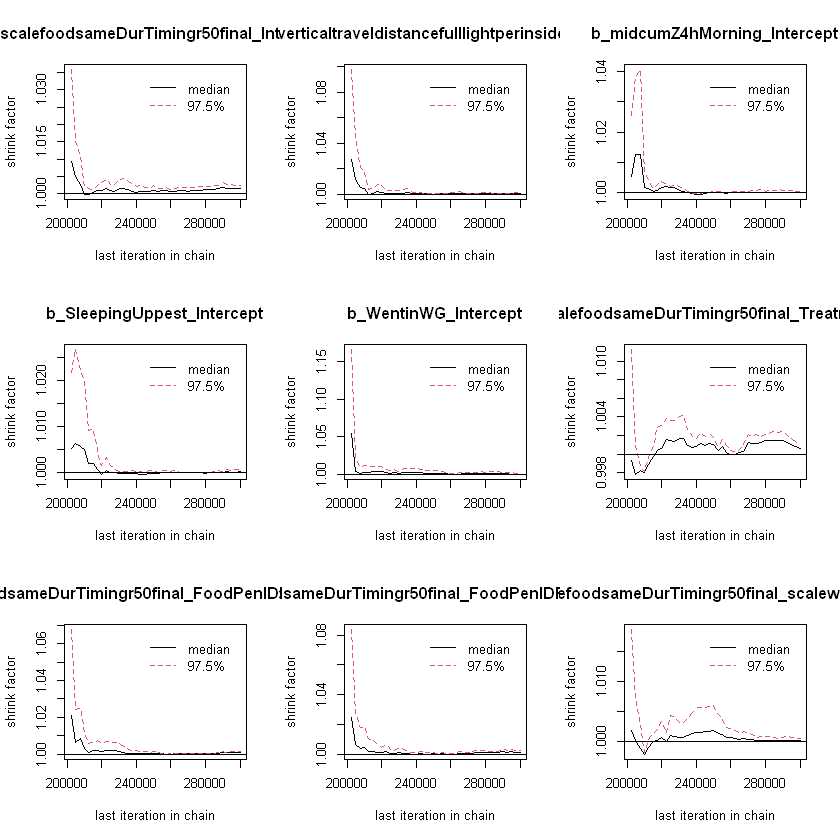

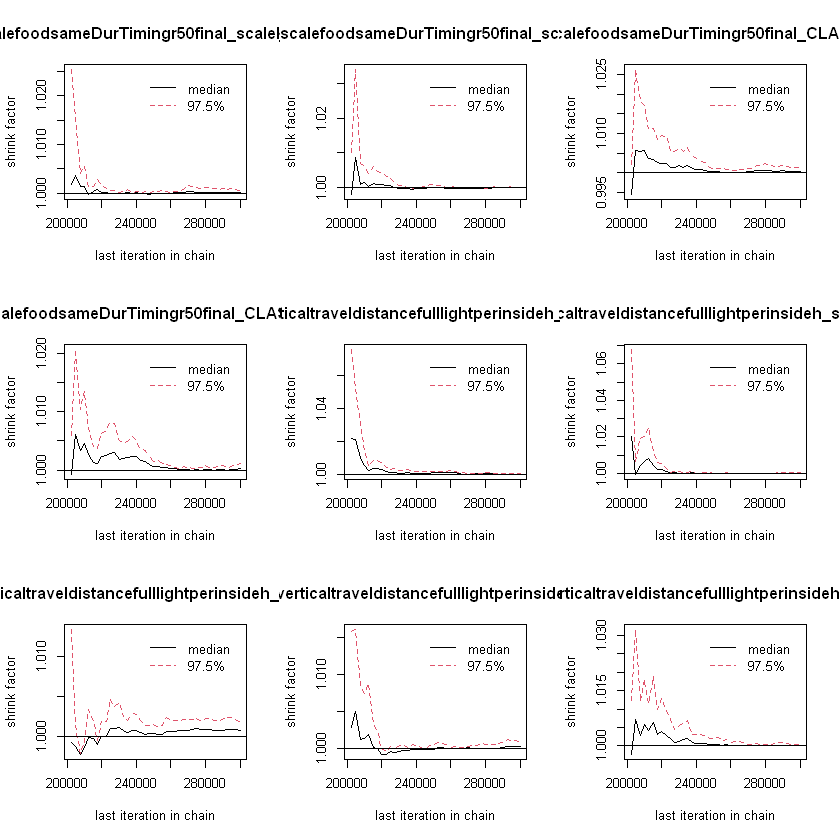

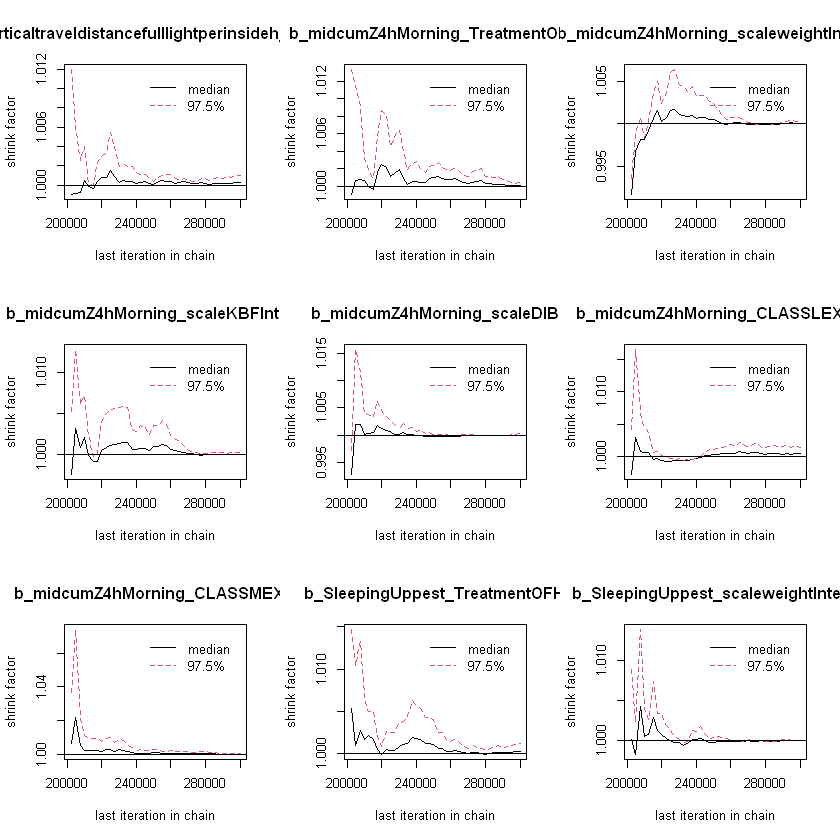

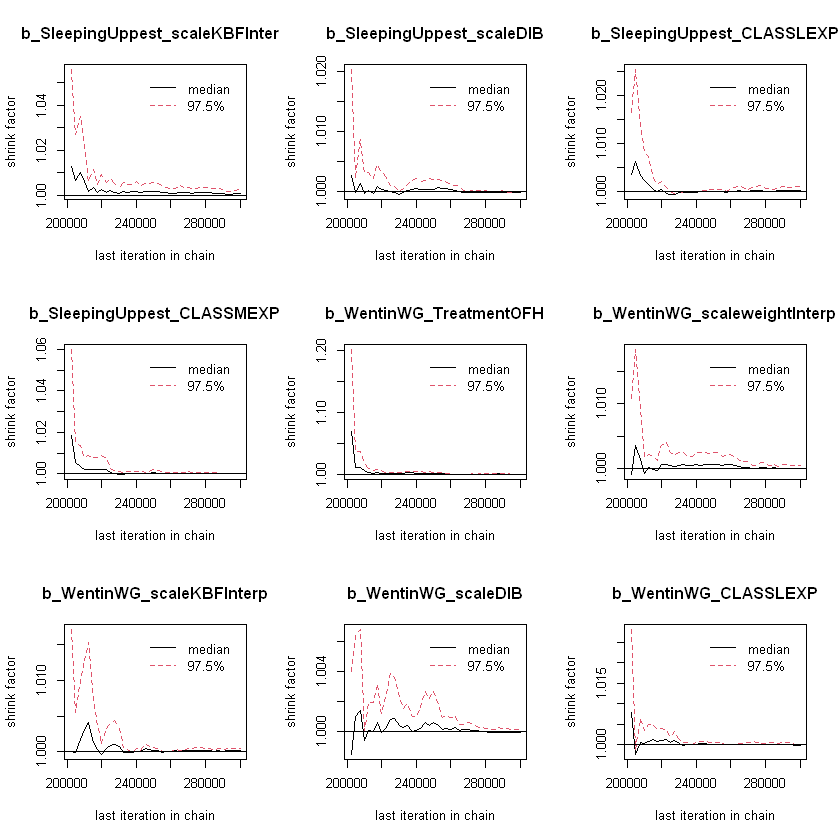

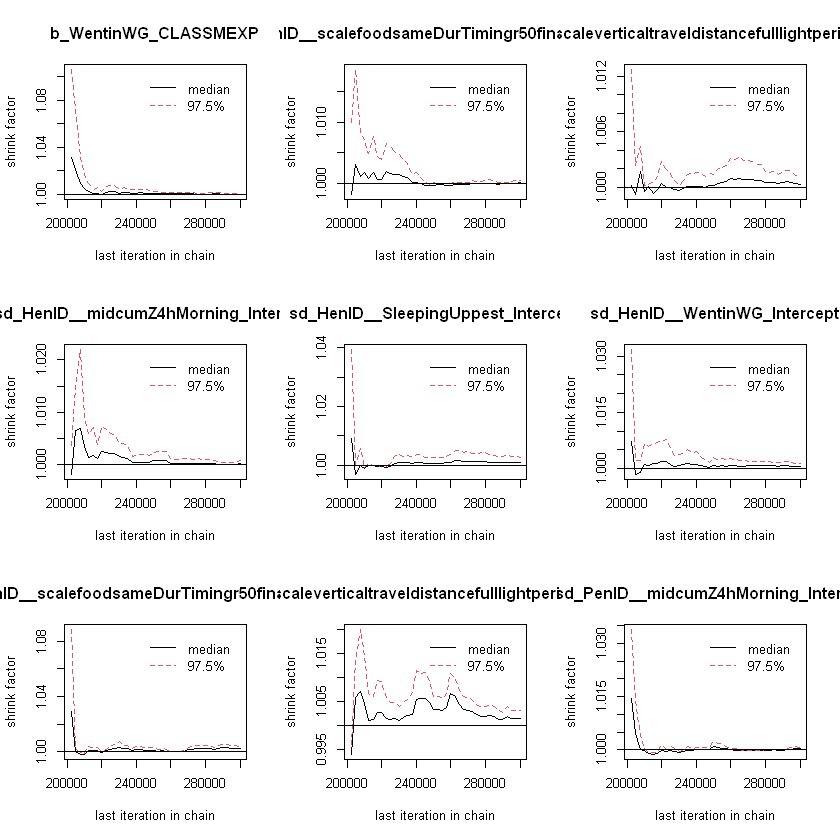

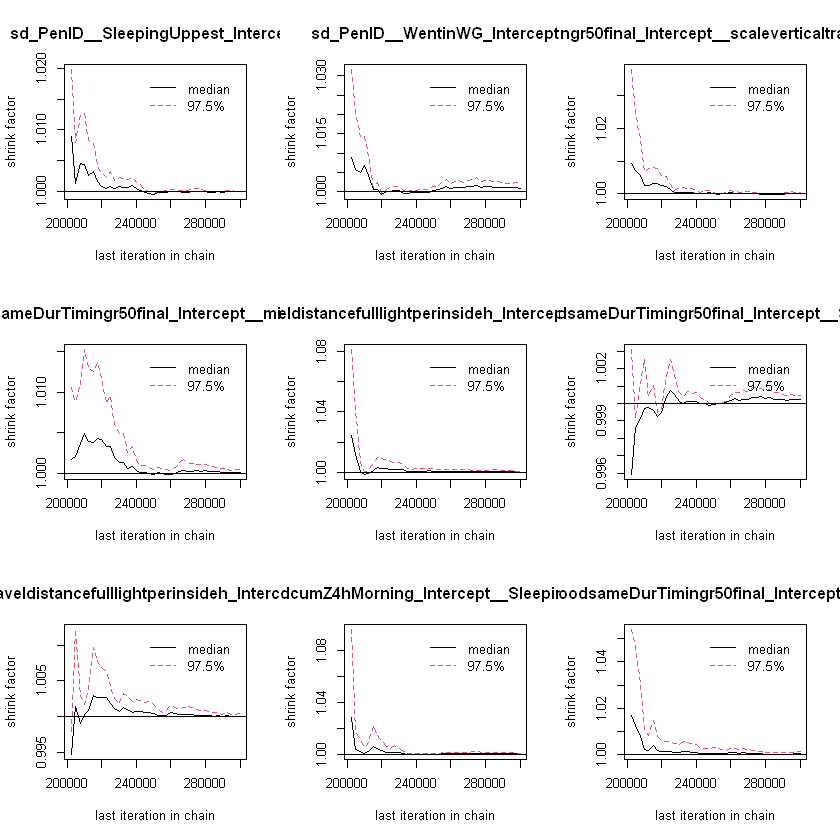

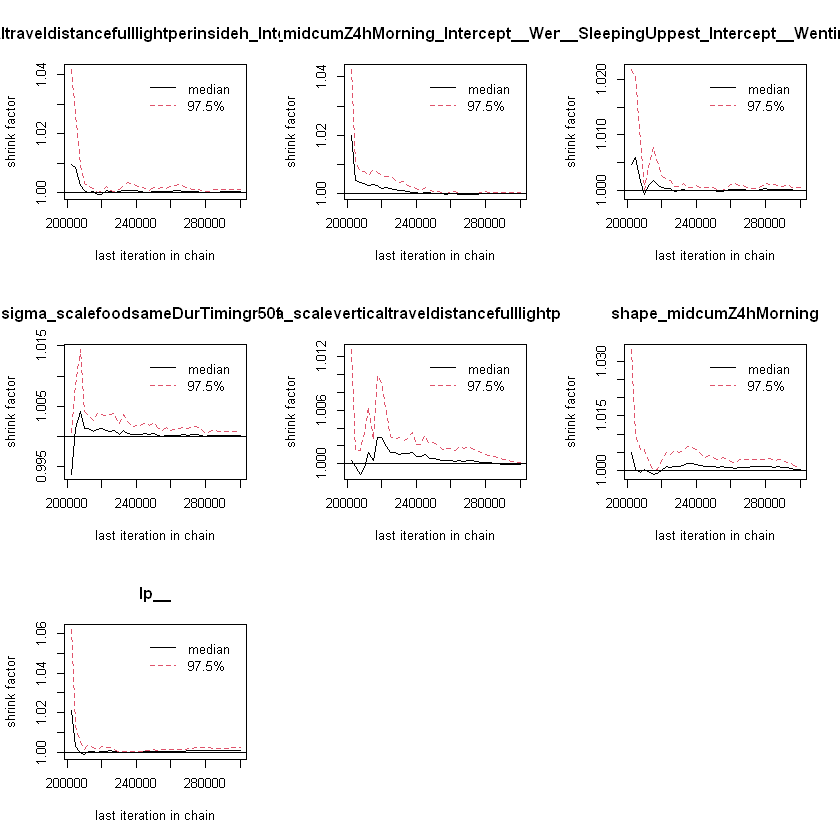

In [22]:
############## Gelman-Rubin diagnostic ##############
#is automatically given in the summary of brms under the column Rhat!
#lets give for all except random intercept (else 1011 plot!!)
modelposterior = as.mcmc(Multi_DHGLM) # with as.mcmc() we can use all the CODA package cvg statistics & plotting options
gelman.diag(modelposterior[, li_param_notR])
gelman.plot(modelposterior[, li_param_notR])

[[1]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

                                                                   b_scalefoodsameDurTimingr50final_Intercept 
                                                                                                      0.52627 
                                                   b_scaleverticaltraveldistancefulllightperinsideh_Intercept 
                                                                                                      0.04775 
                                                                                 b_midcumZ4hMorning_Intercept 
                                                                                                      1.11039 
                                                                                   b_SleepingUppest_Intercept 
                                                                                                      0.35440 
                                             

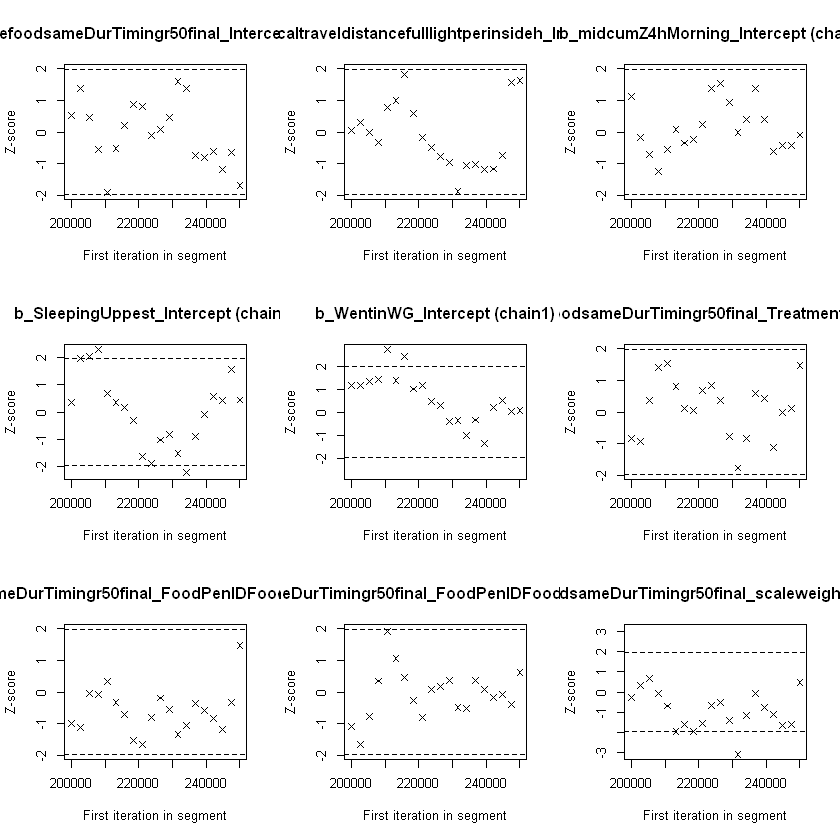

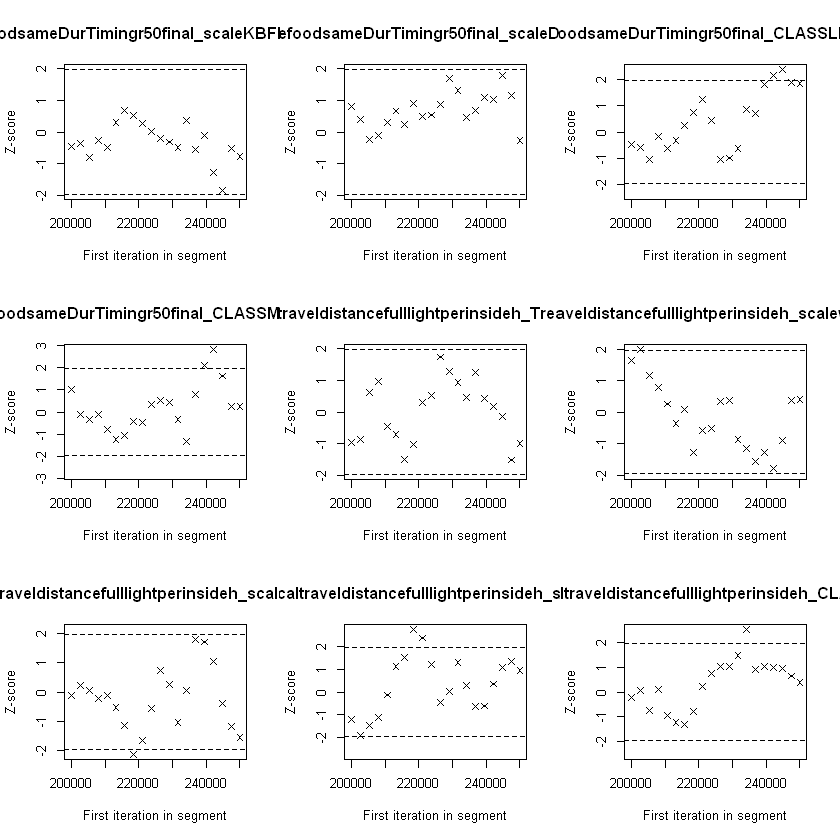

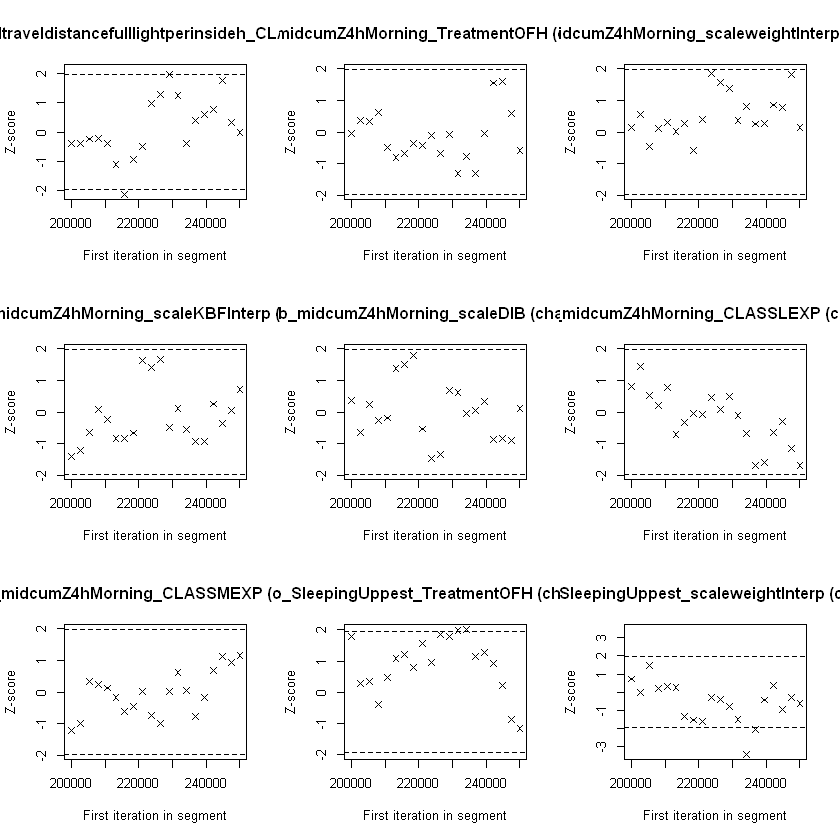

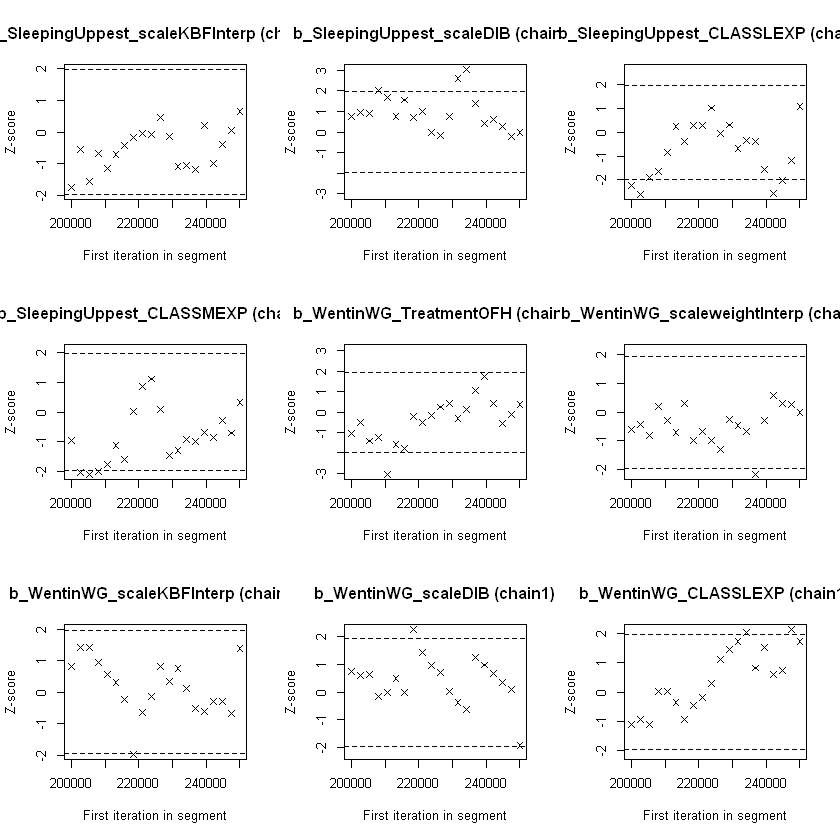

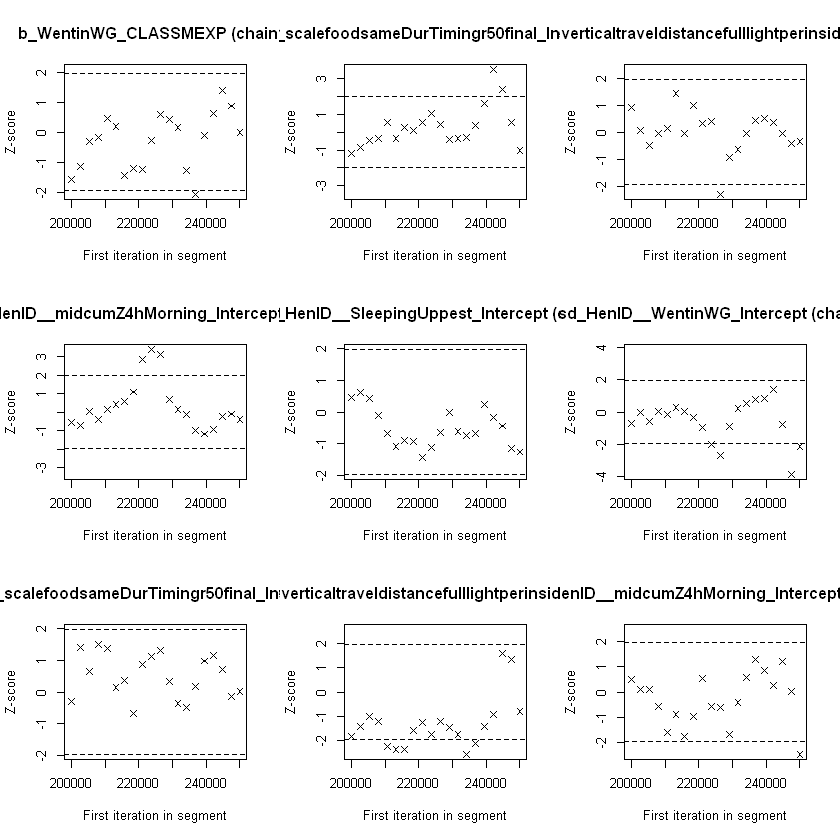

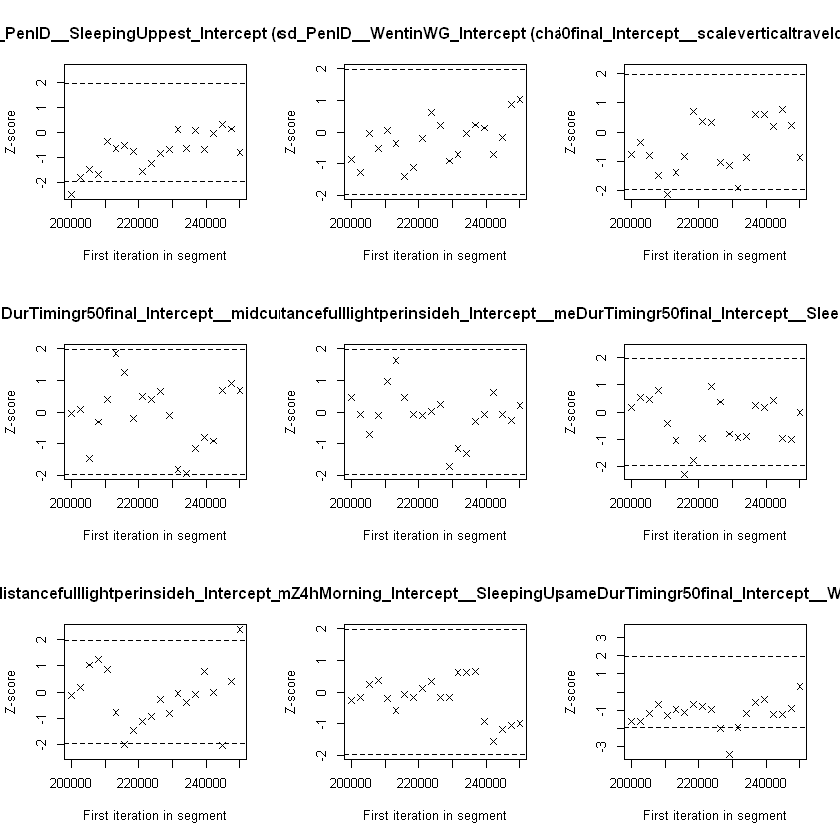

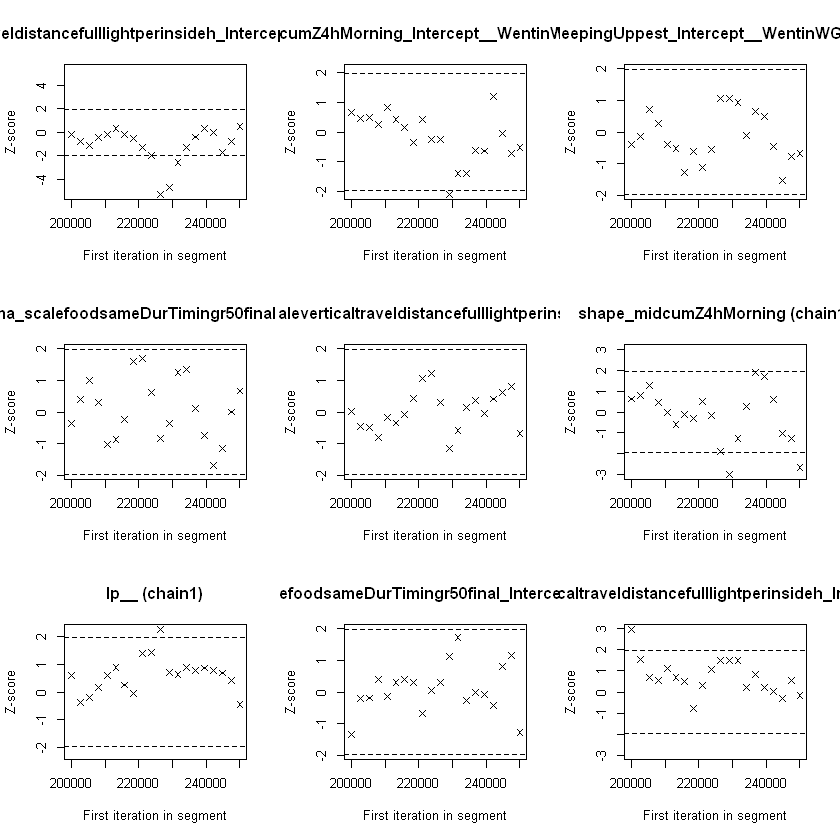

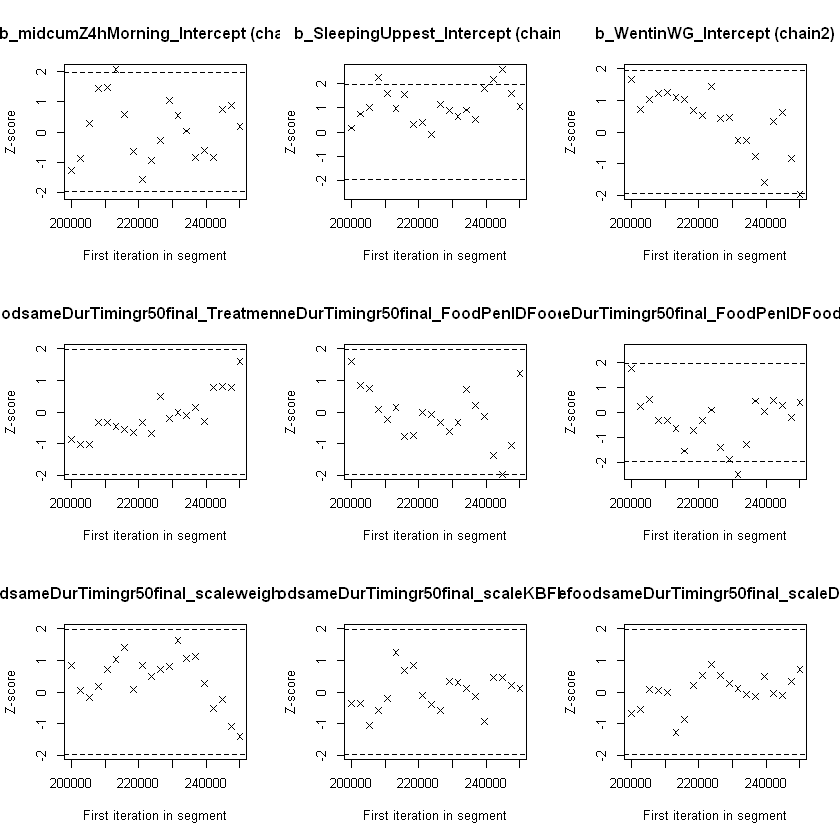

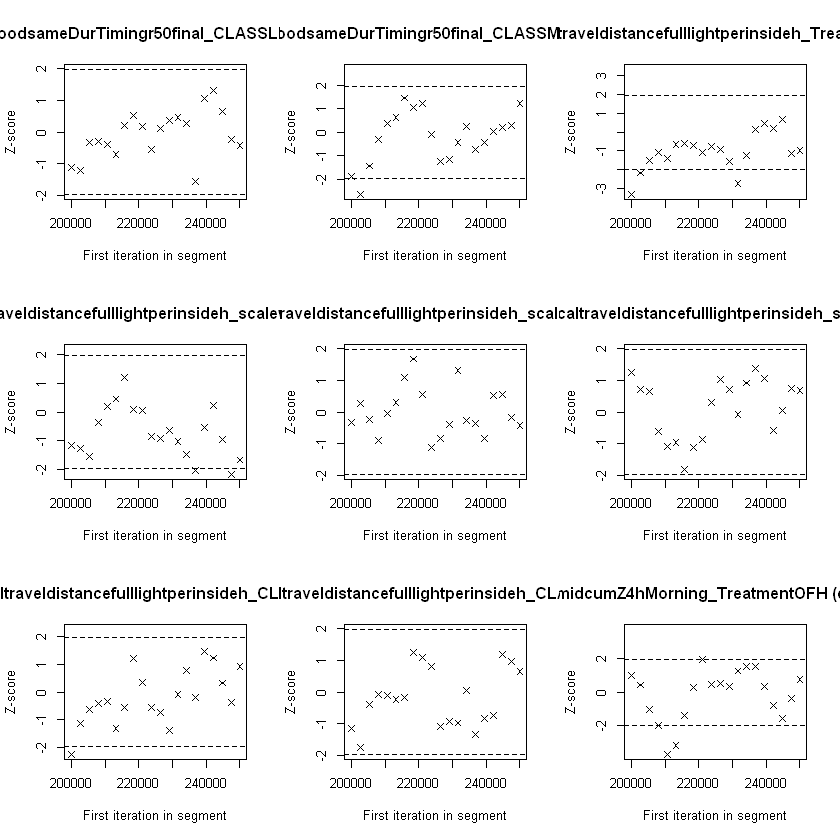

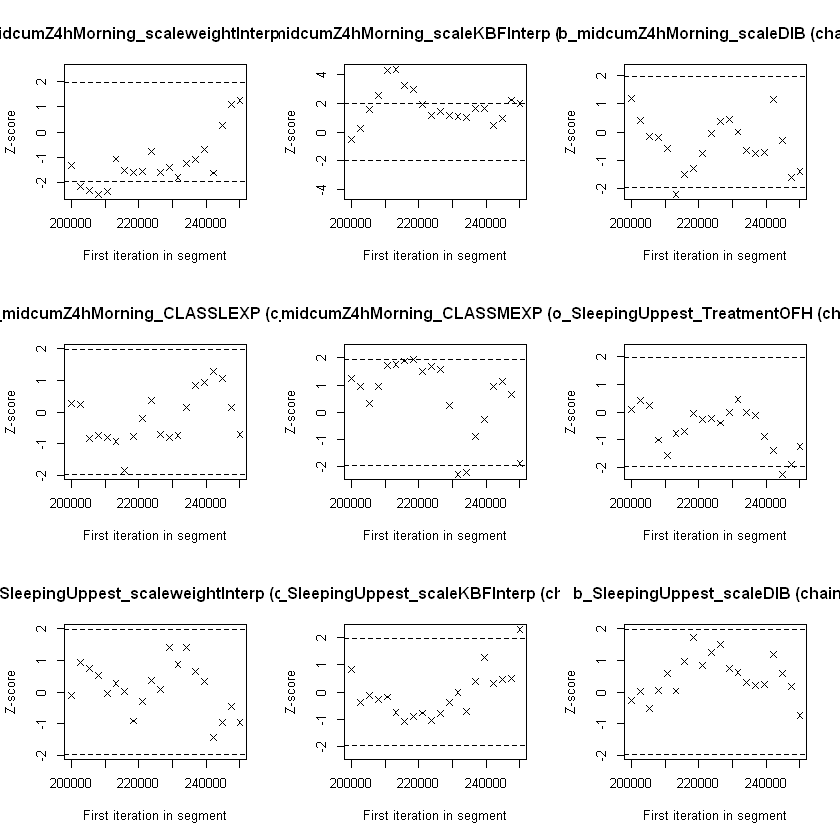

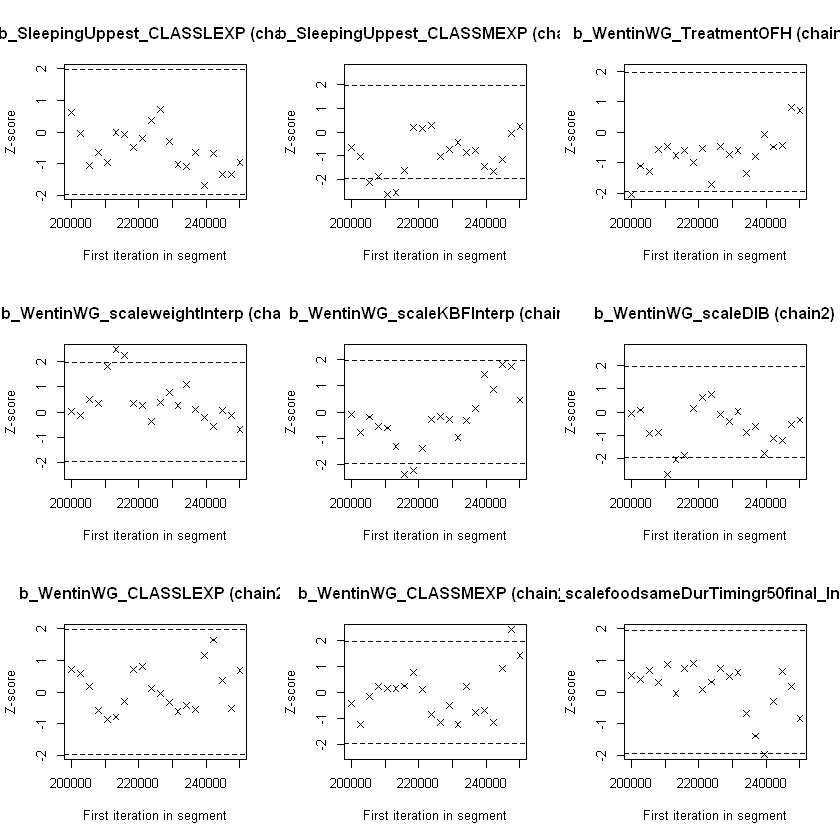

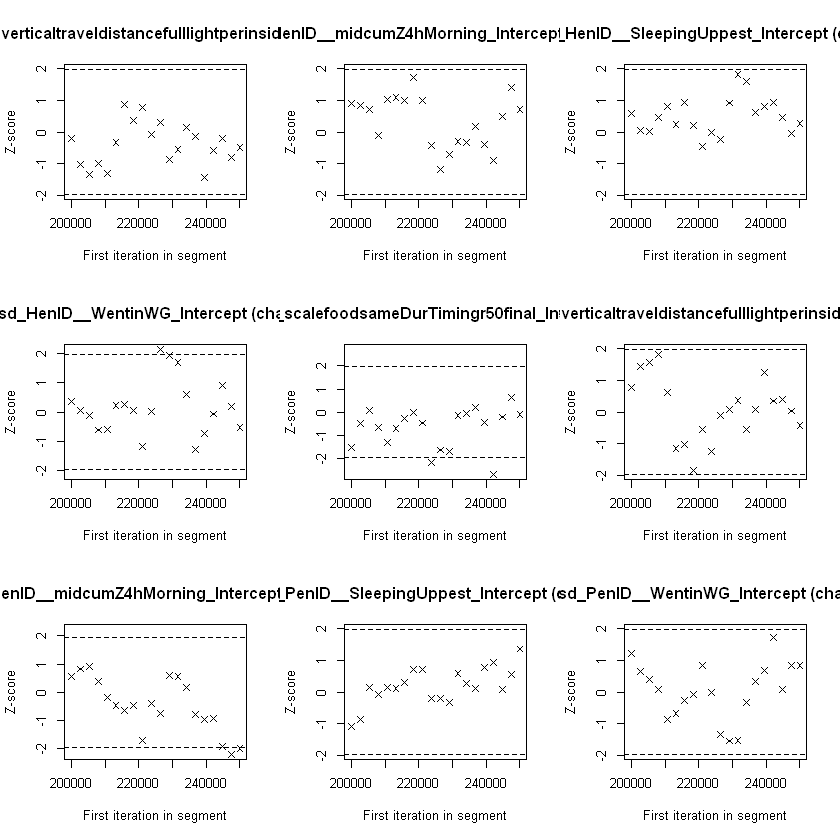

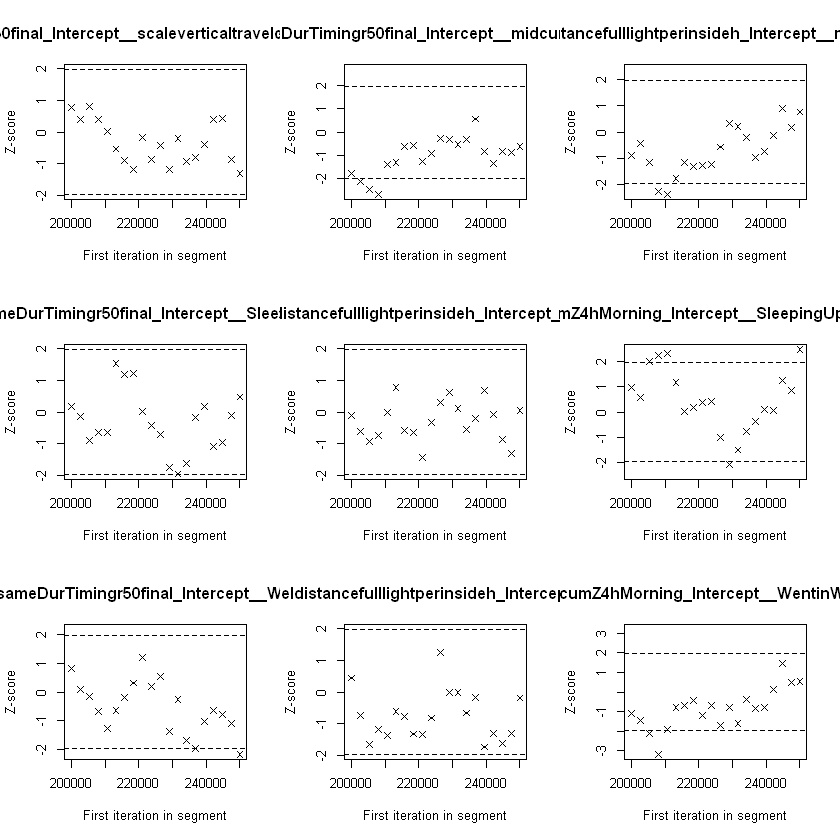

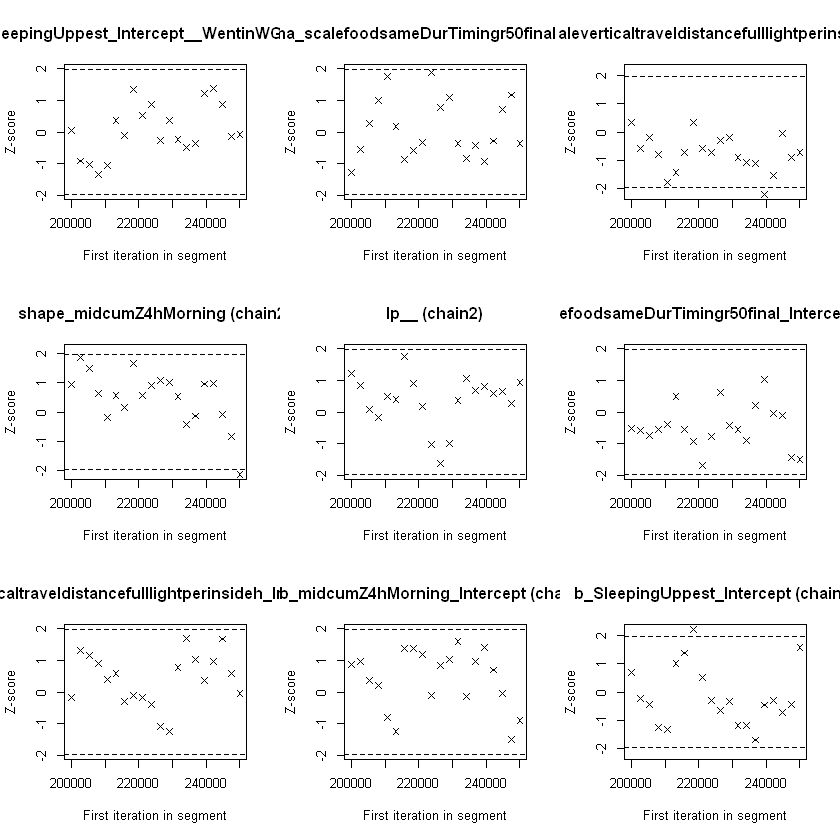

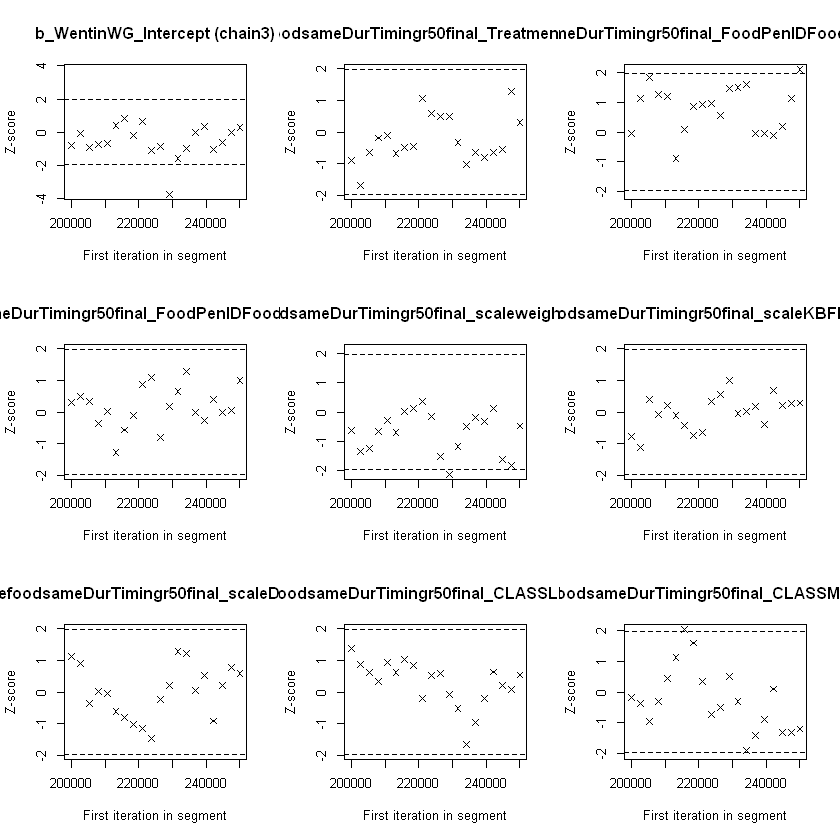

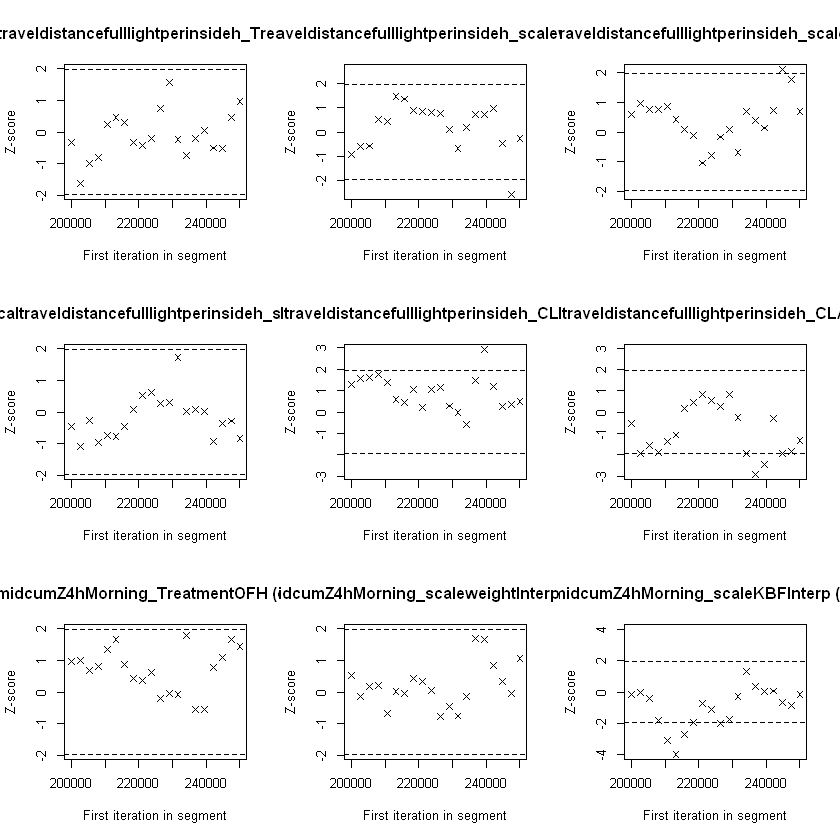

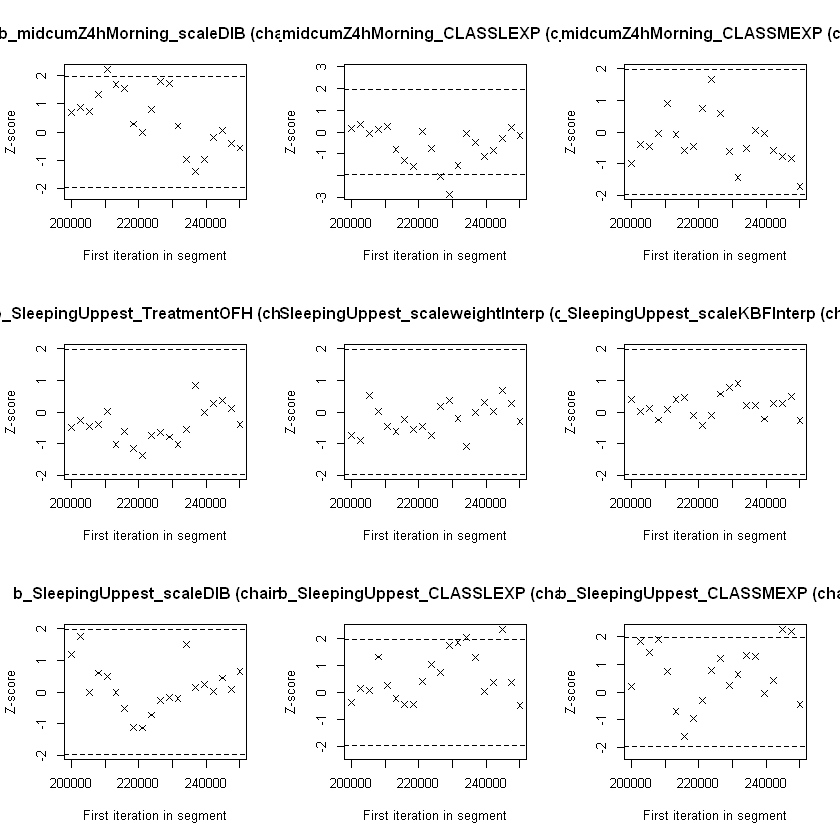

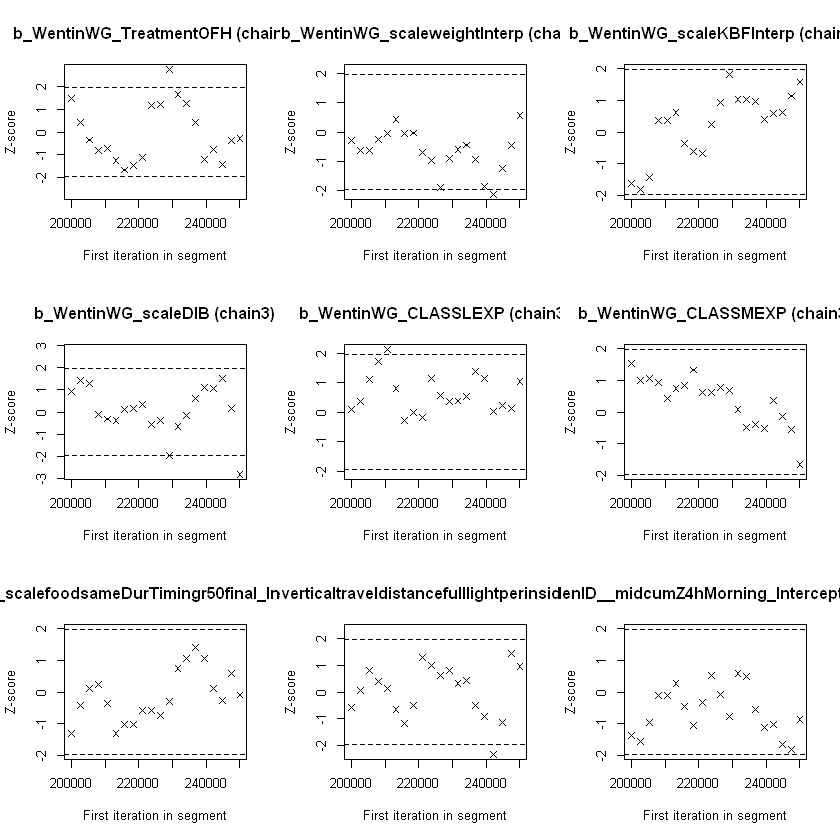

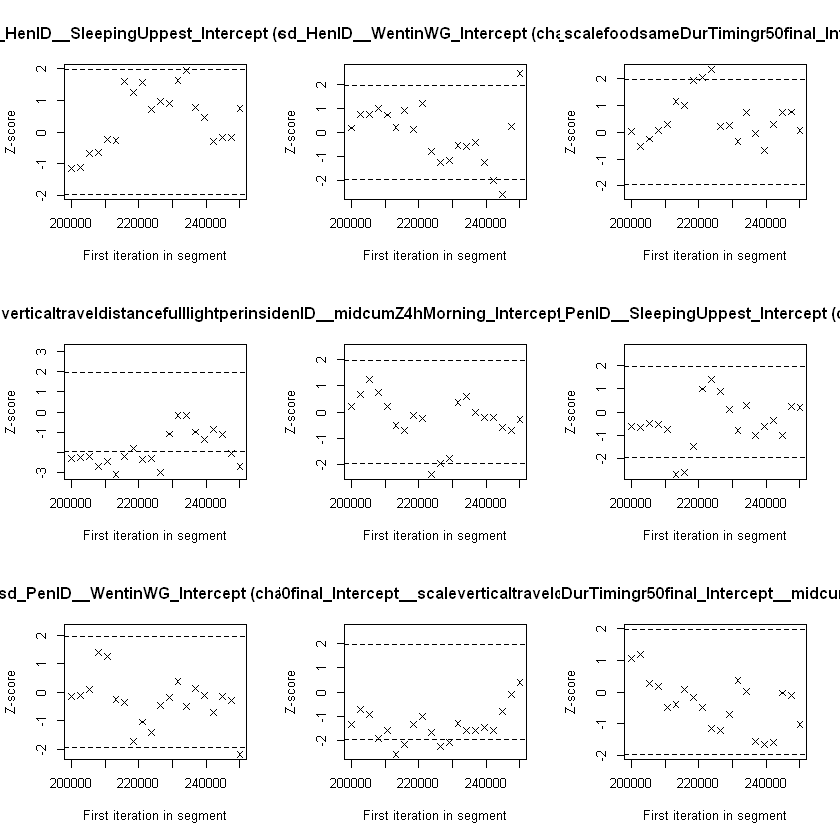

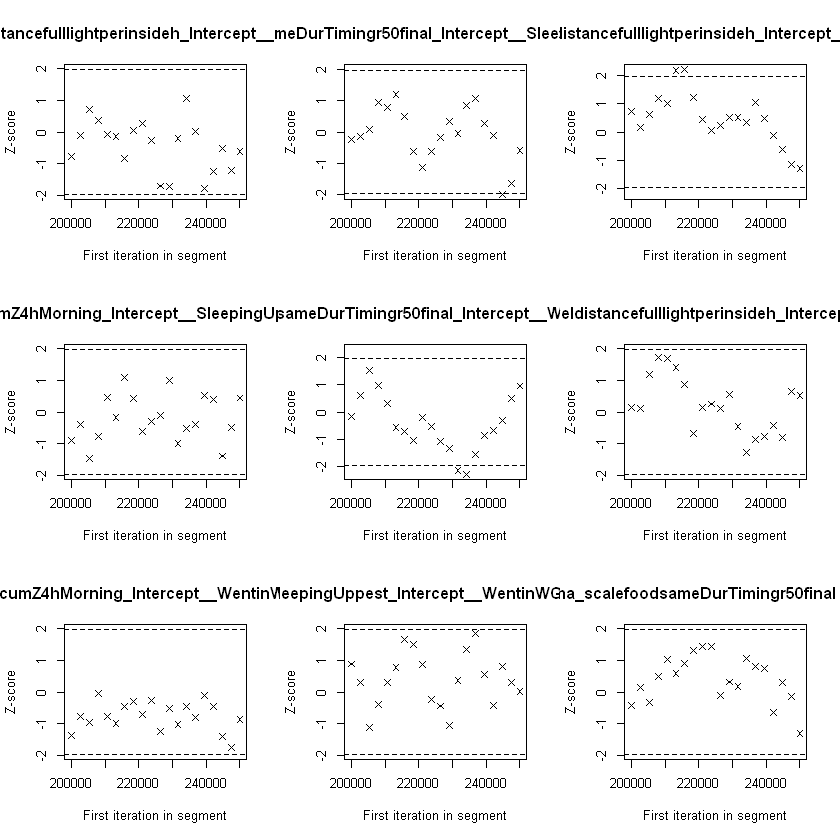

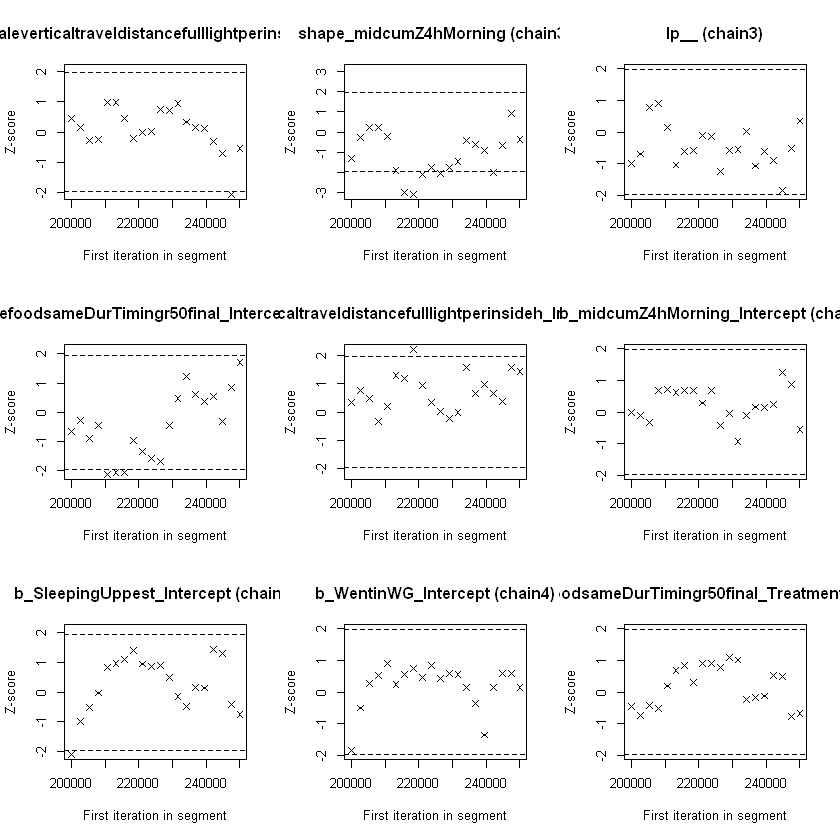

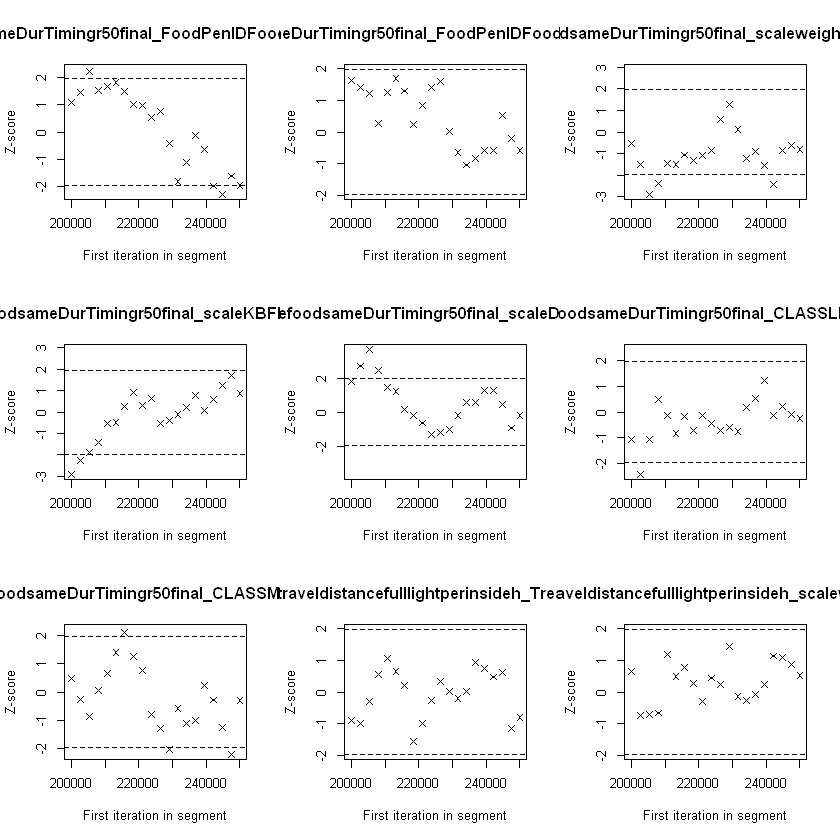

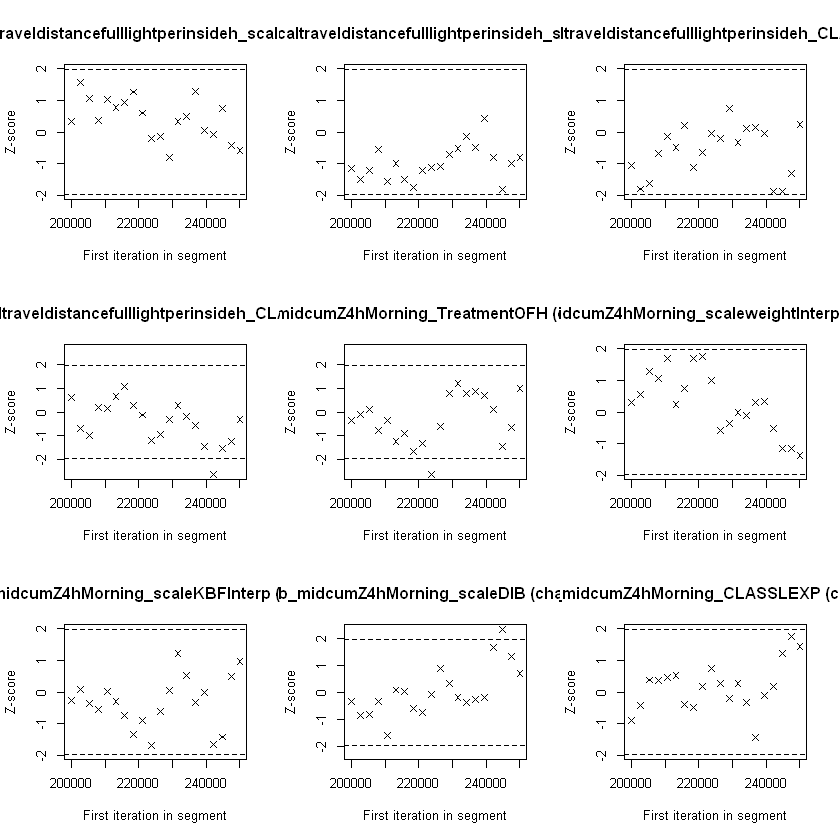

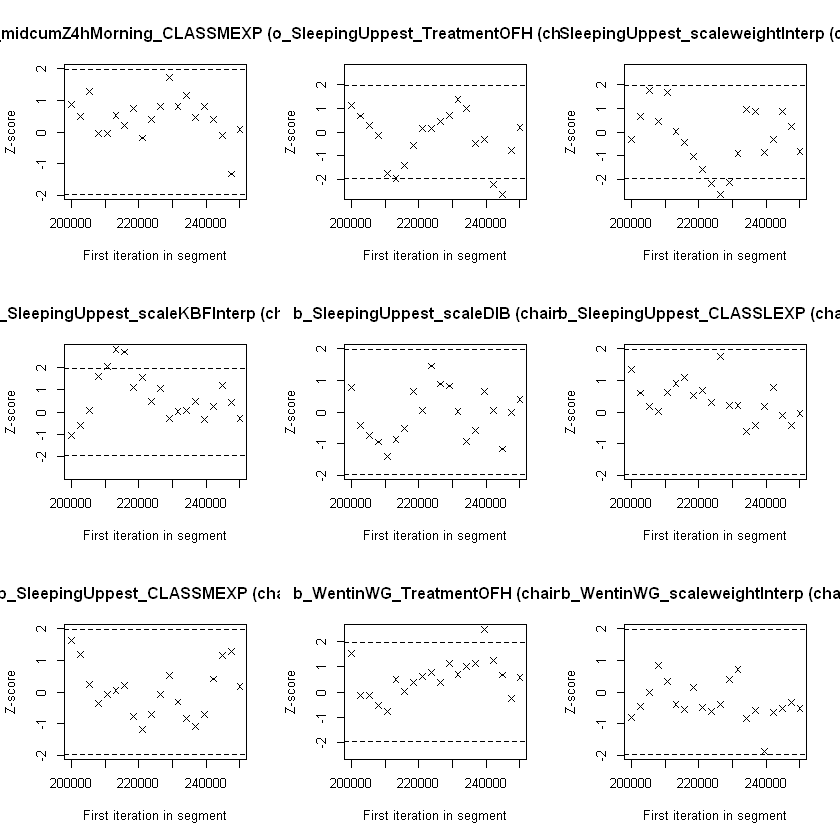

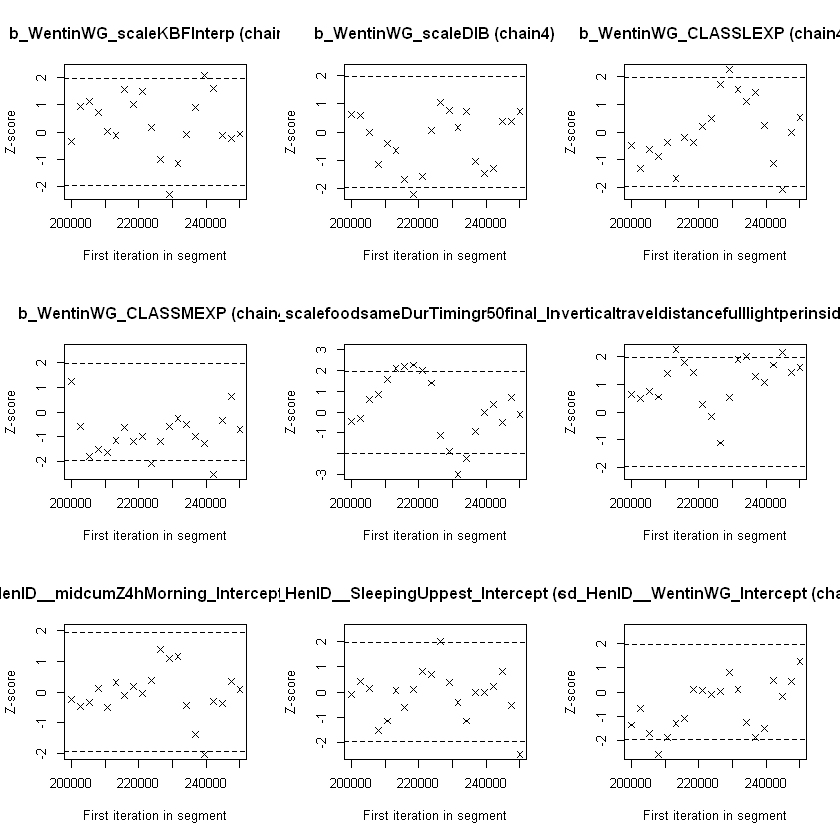

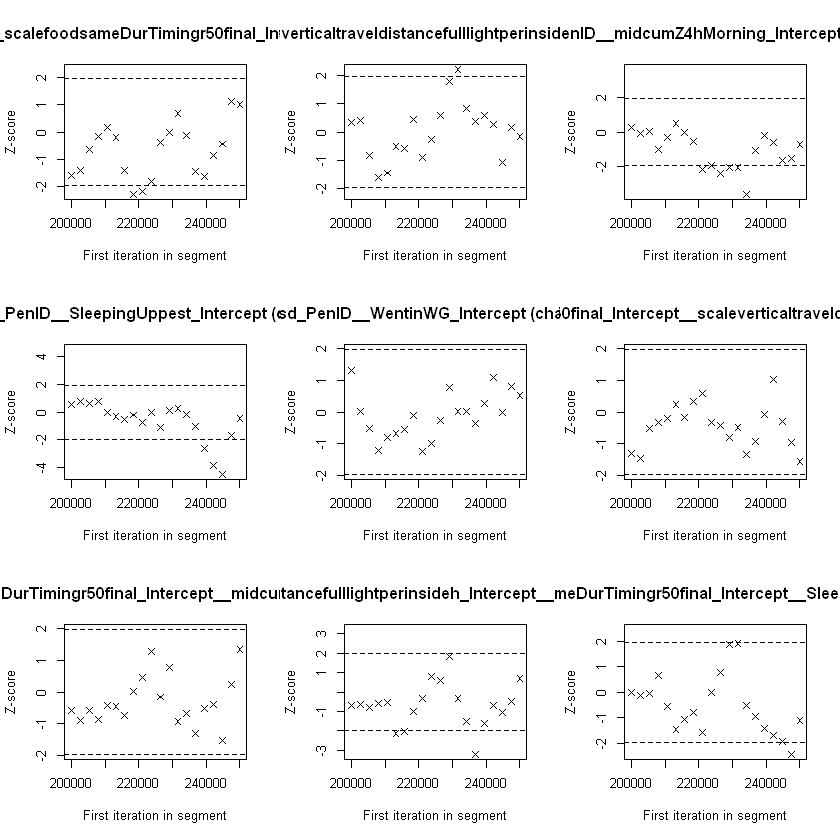

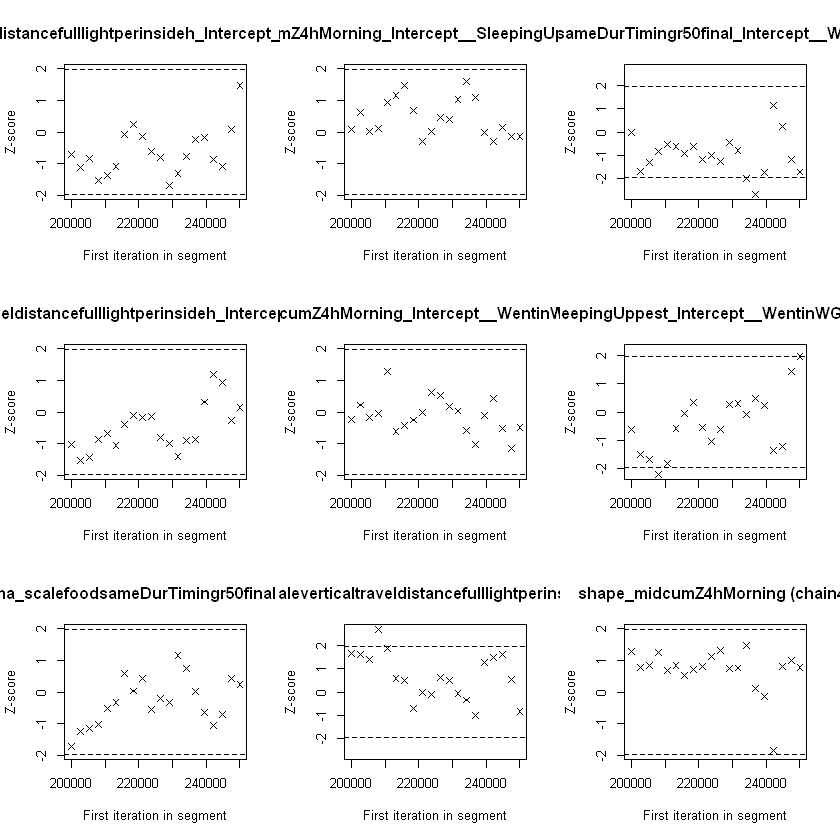

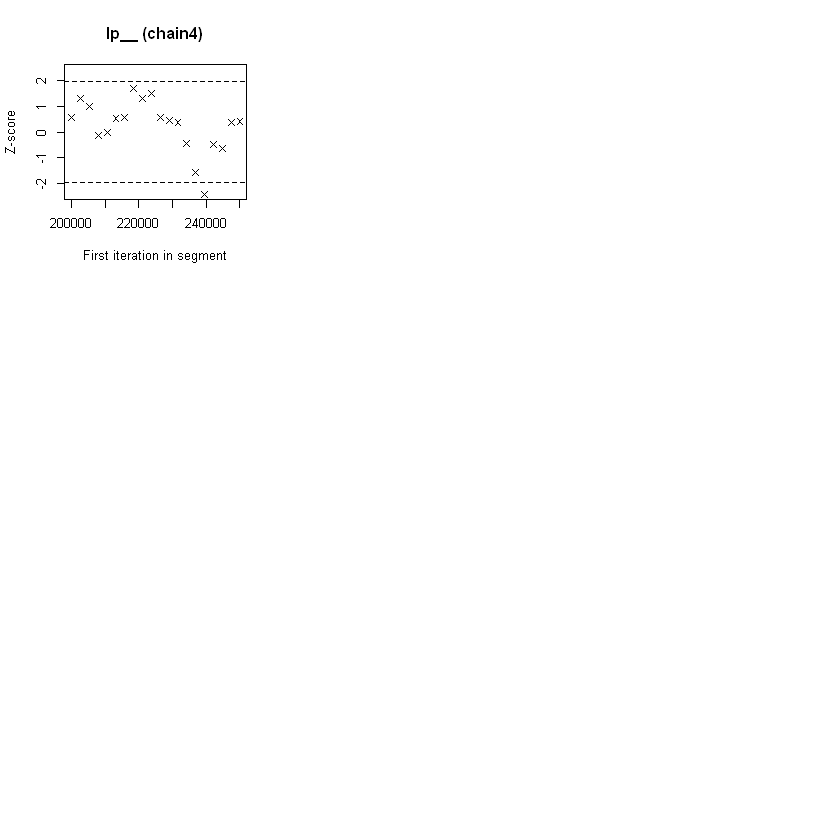

In [23]:
############## Geweke diagnostic ##############
#shows the z-scores for a test of equality of means between the first and last parts of each chain, which should be <1.96
geweke.diag(modelposterior[, li_param_notR])
geweke.plot(modelposterior[, li_param_notR])
#sd_HenID__foodsameDurTimingr50final_Intercept : BAD: 2.61144, with more iterations we have: 0.94243 
#cor_HenID__foodsameDurTimingr50final_Intercept__SleepingUppest_Intercept : 2.11821, with more iterations we have: 1.18771
#others too
#each [[*]] correspond to chain *
#sigma_scaleverticaltraveldistancefulllightperinsideh stil to large, b_SleepingUppest_TreatmentOFH too etc

[1] 10

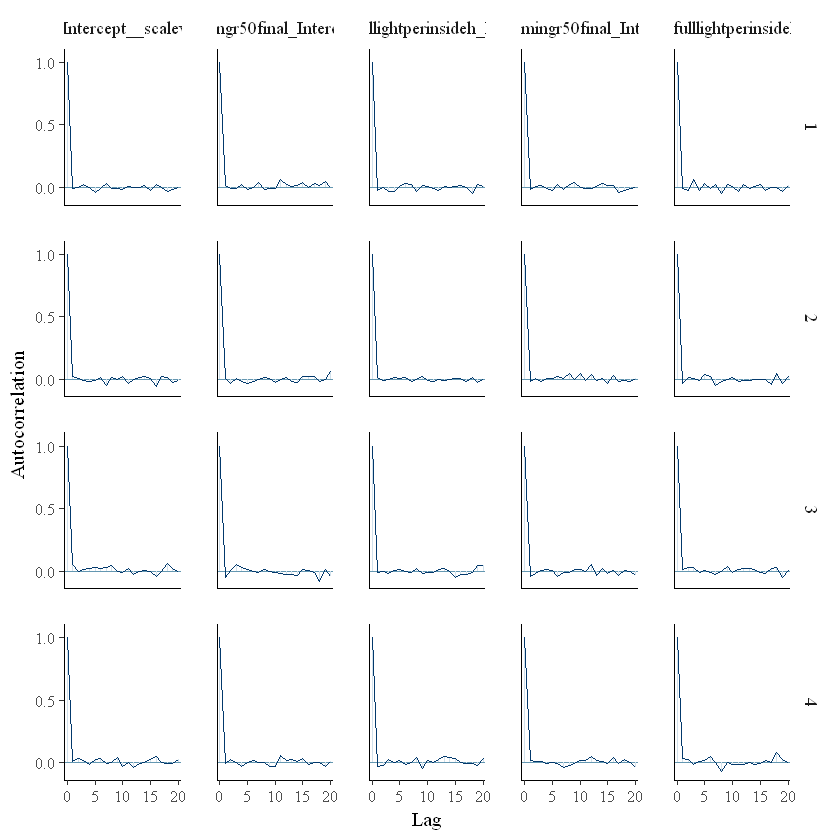

[1] 37

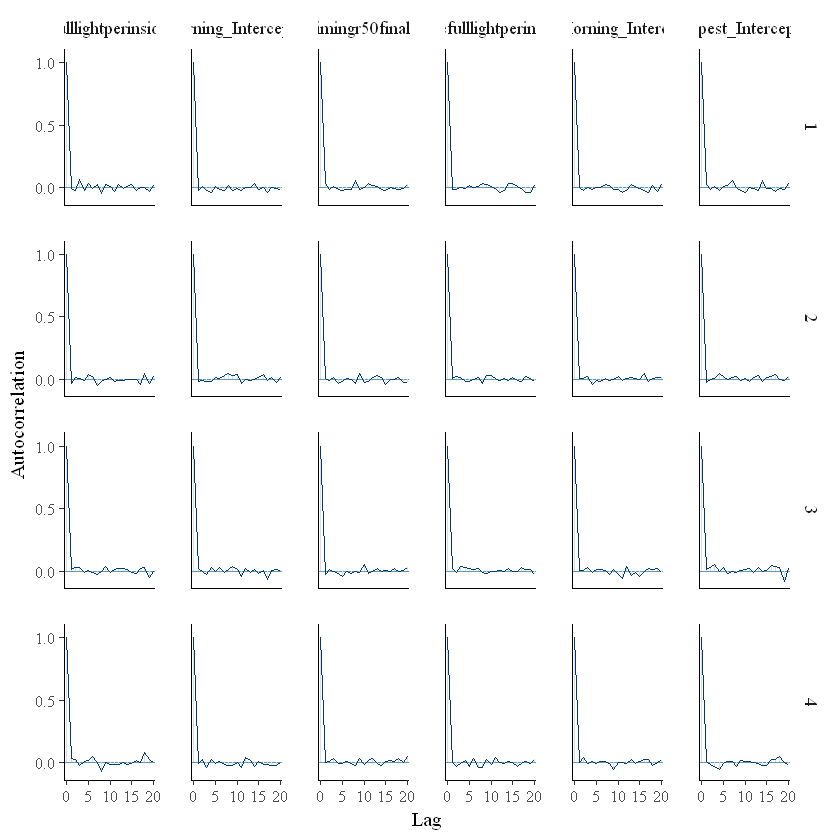

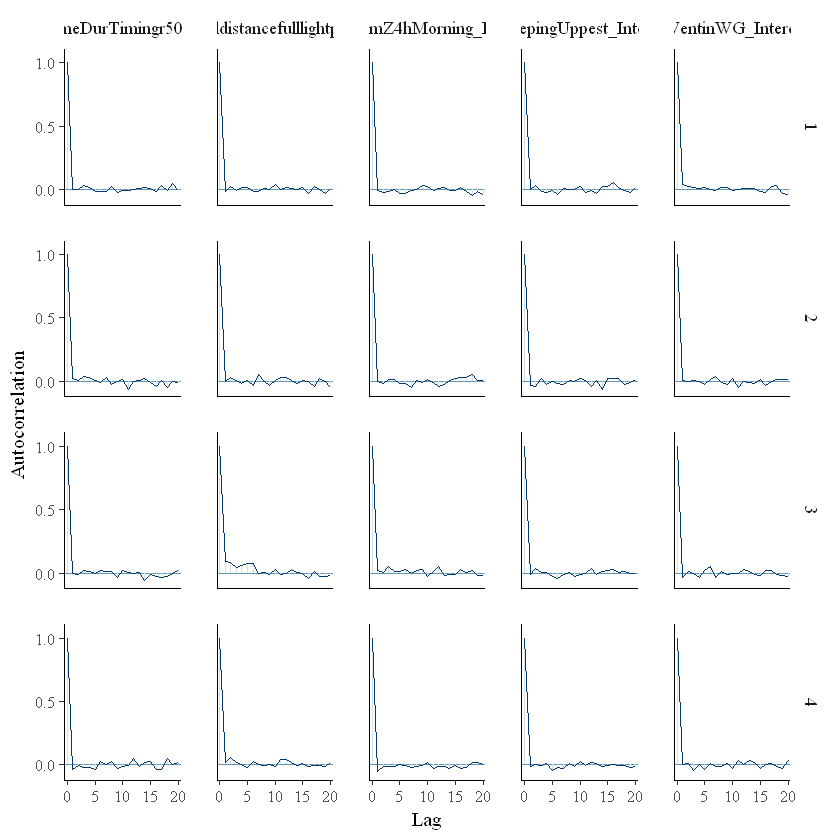

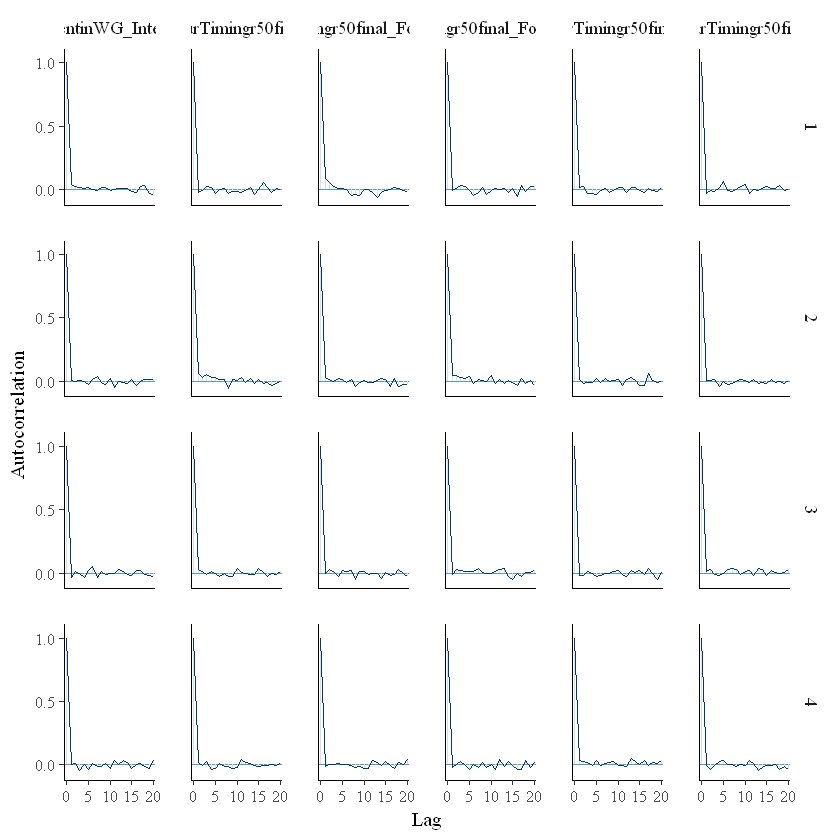

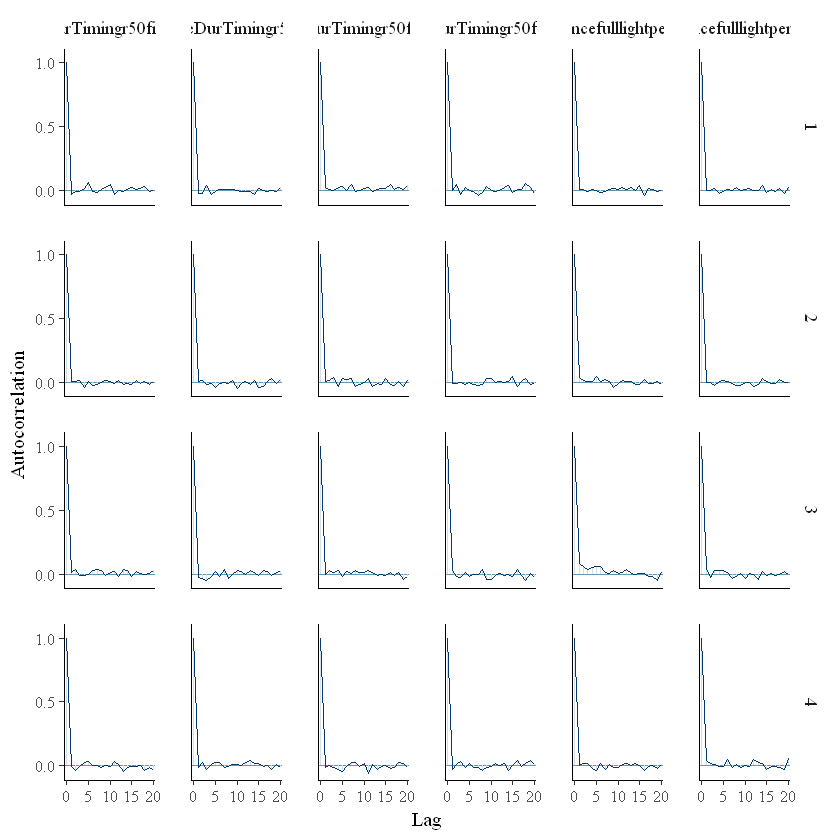

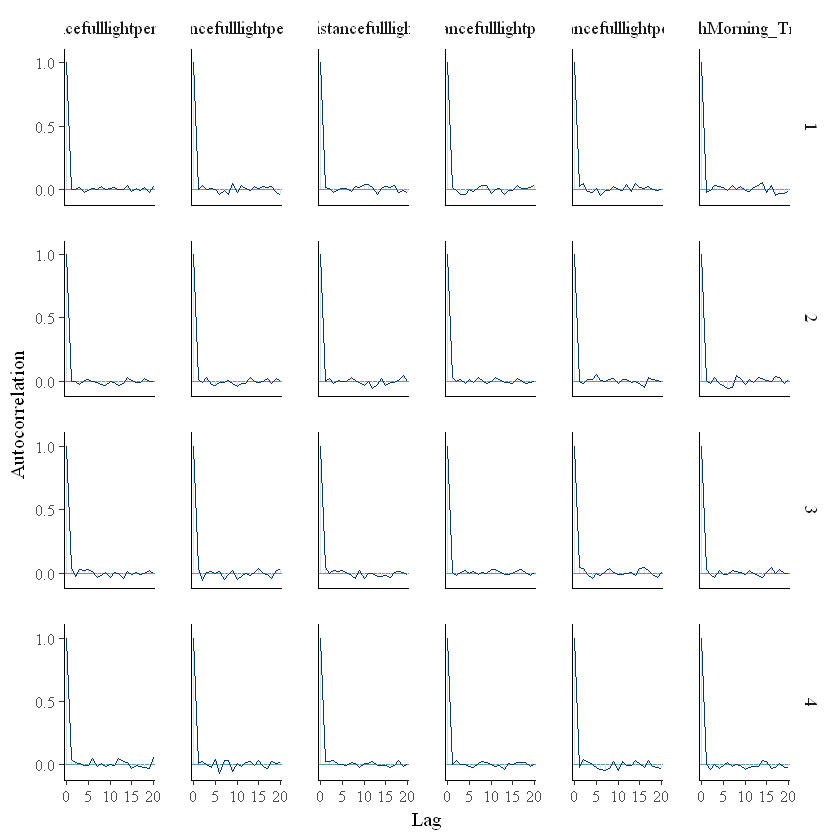

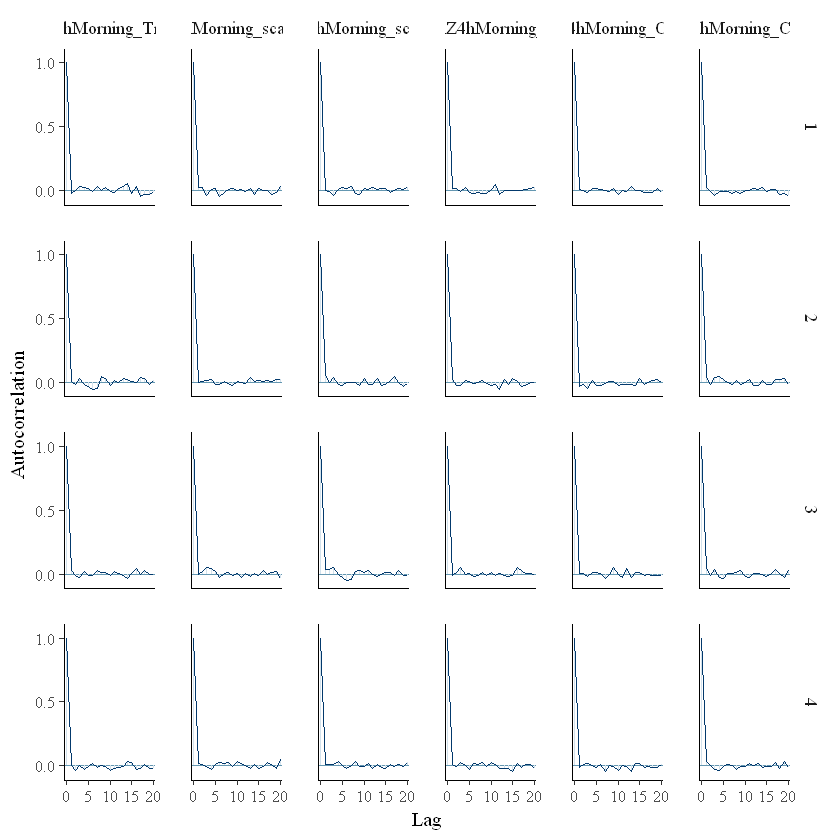

[1] 2

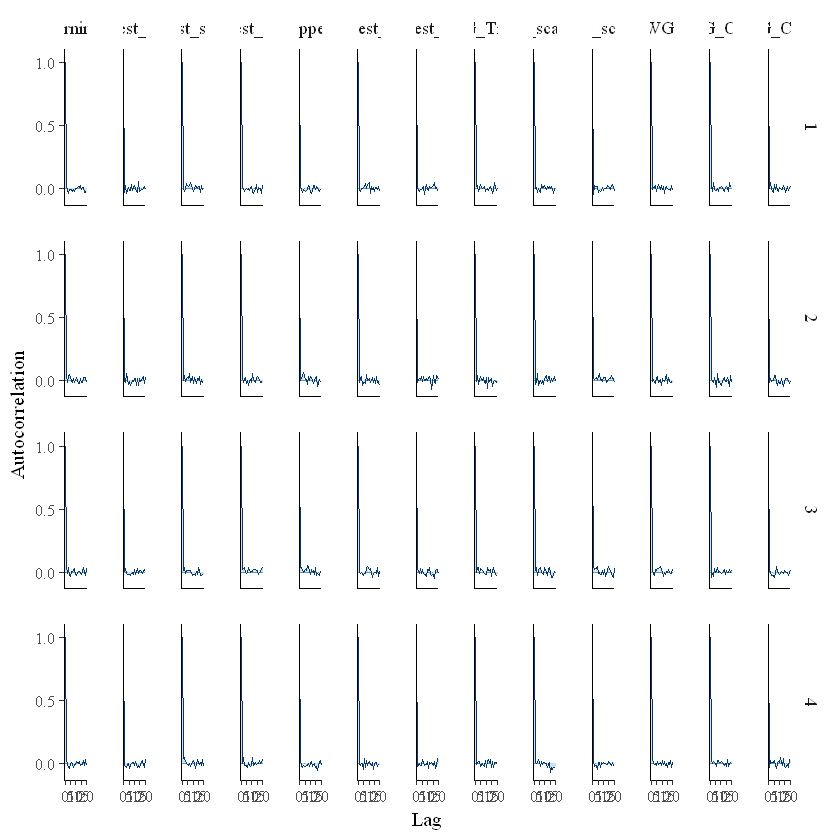

[1] 10

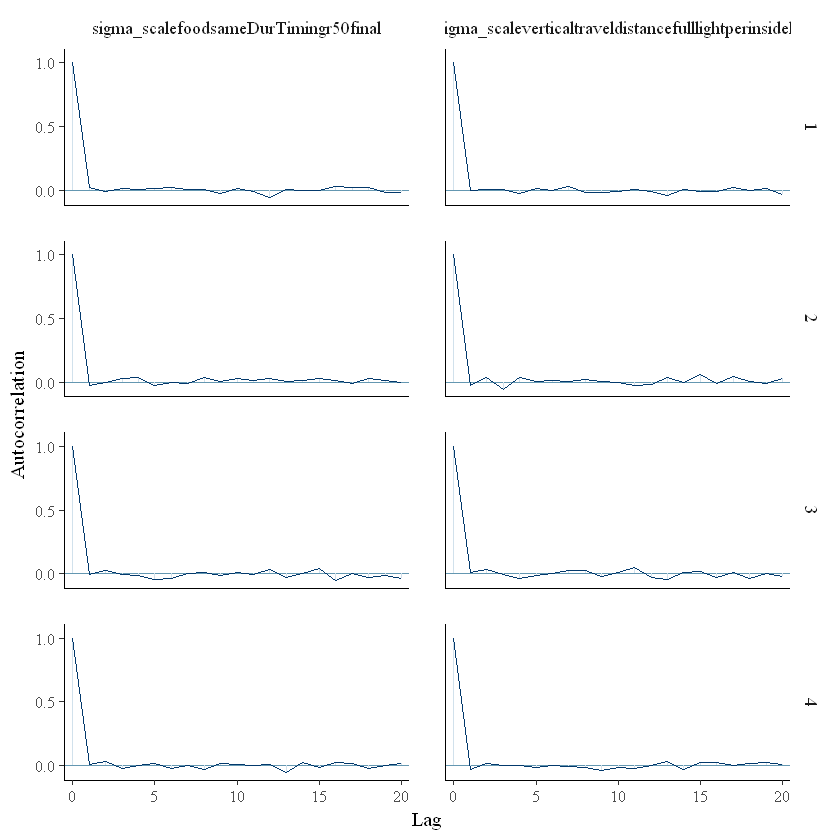

[1] 1

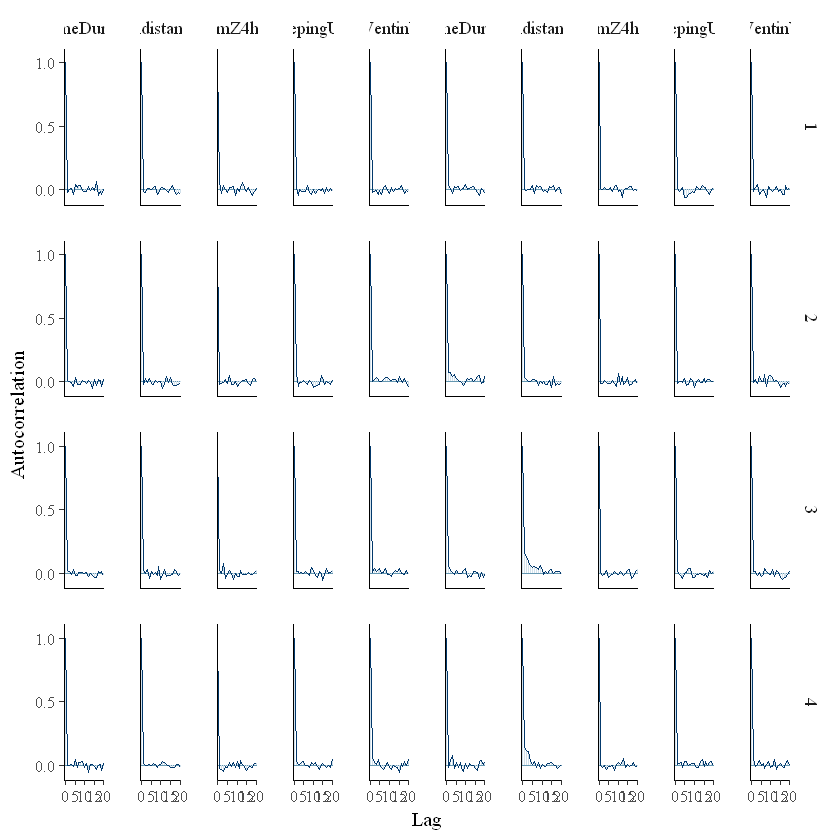

[1] 1

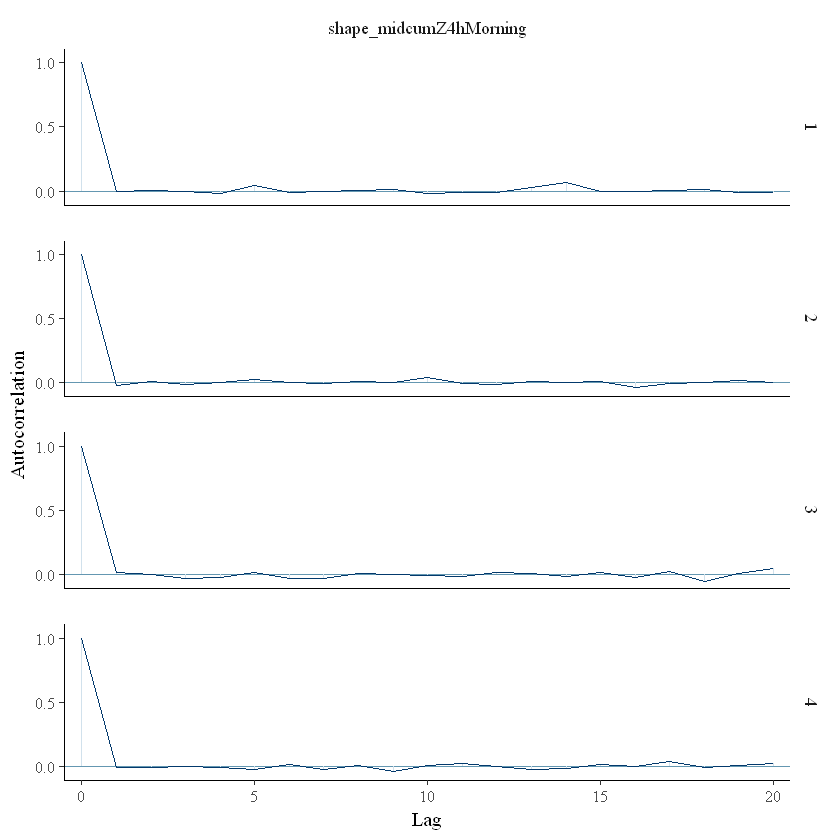

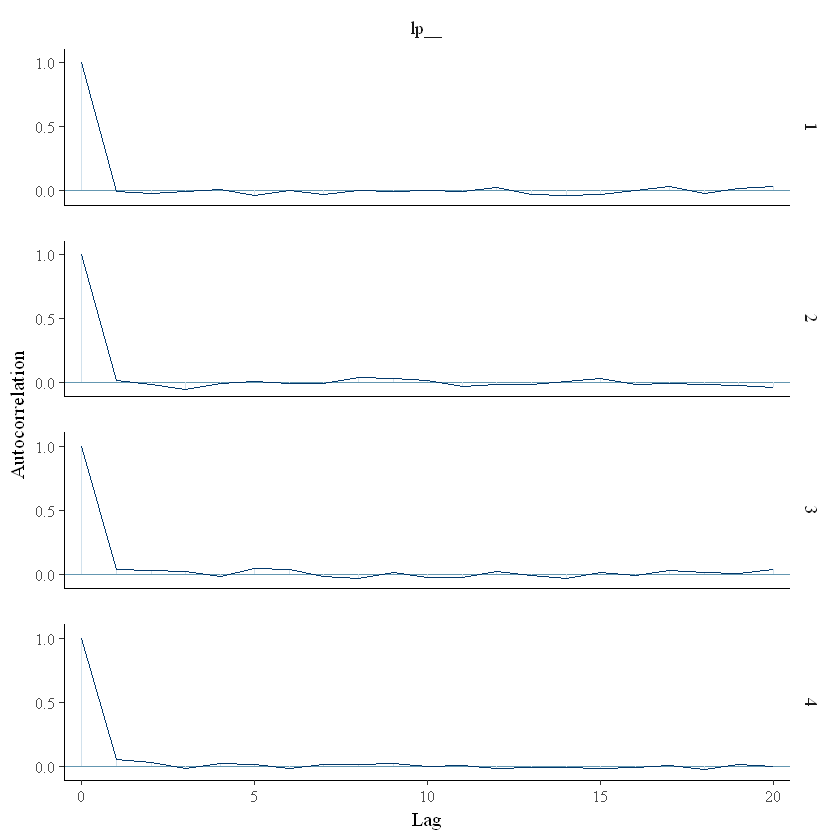

In [24]:
############## do the chains exhibit a strong degree of autocorrelation? ##############
#if we want to do, read this paper first On thinning of chains in MCMC
cond = lapply(li_param, function(x) startsWith(x, 'cor_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[1:5])
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[5:length(li_param_)])

cond = lapply(li_param, function(x) startsWith(x, 'b_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[1:5])   
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[5:10])  
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[10:15])  
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[15:20])    
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[20:25])   
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_[25:length(li_param_)])   
             
cond = lapply(li_param, function(x) startsWith(x, 'sigma_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_)   
              
cond = lapply(li_param, function(x) startsWith(x, 'sd_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_)   
                            
cond = lapply(li_param, function(x) startsWith(x, 'shape_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_)   

cond = lapply(li_param, function(x) startsWith(x, 'lp_'))
li_param_ = li_param[unlist(cond)]
length(li_param_) #nbr param without random intercepts
mcmc_plot(Multi_DHGLM, type = "acf", variable=li_param_)   

#takes too long
############## results differ when augmenting the number of iteration? check for bais ##############
#from: https://www.rensvandeschoot.com/tutorials/wambs-checklist-in-r-using-brms/
#To get the relative bias simply save the means of the regression coefficients and other parameters (ignore lp__ for now) for the two different analyses and compute the bias.
FA = bf(scale(food_sameDurTiming_r50_final) ~ Treatment + FoodPenID + scale(weightInterp) + scale(KBFInterp) + scale(DIB)+CLASS+ (1|a|HenID),
       family=gaussian)
VTD = bf(scale(vertical_travel_distance_fulllight_perinsideh) ~ Treatment + scale(weightInterp)+scale(KBFInterp)+scale(DIB) +CLASS+(1|a|HenID),
        family=gaussian)
TM = bf(mid_cum_Z4_h_Morning ~ Treatment + scale(weightInterp) + scale(KBFInterp) + scale(DIB) +CLASS+ (1|a|HenID),
       family=Gamma(link='log'))
SD = bf(Sleeping_Uppest ~ Treatment + scale(weightInterp)+scale(KBFInterp) + scale(DIB) +CLASS+ (1|a|HenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
WG = bf(WentinWG ~ Treatment+scale(weightInterp)+scale(KBFInterp) + scale(DIB)+CLASS+(1|a|HenID), 
        family = bernoulli(link = "logit")) #binary logistic regression
model_moreiter = brm(FA + VTD + TM + SD + WG +
                    set_rescor(FALSE),
                    data = df,
                    iter = round(iter_*0.8,0), warmup = round(iter_wu*0.8,2), thin = 4,
                    chains = 4, cores =my.cores, seed = 12345
                    )
summary(model_moreiter)
round(100*((posterior_summary(model_moreiter)[,"Estimate"] - posterior_summary(Multi_DHGLM)[,"Estimate"]) / posterior_summary(Multi_DHGLM)[,"Estimate"]), 4)
#If the relative bias is small enough (<5%), do not worry about it.